In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
harvard = pd.read_csv('./data/harvard_feature_engineered.csv', sep=";", decimal=",")
triage = pd.read_csv('./data/triage_feature_engineered.csv', sep=";", decimal=",")

# Harvard

In [3]:
binary_vars = harvard.columns[harvard.nunique() == 2].drop('Exacerbation')
categorical_vars = harvard.columns[(harvard.nunique() > 2) & (harvard.nunique() < 10)]
continuous_vars = harvard.columns[harvard.nunique() > 10]
print(len(binary_vars), len(categorical_vars), len(continuous_vars))

59 15 28


## Plot Binary Vars

KeyboardInterrupt: 

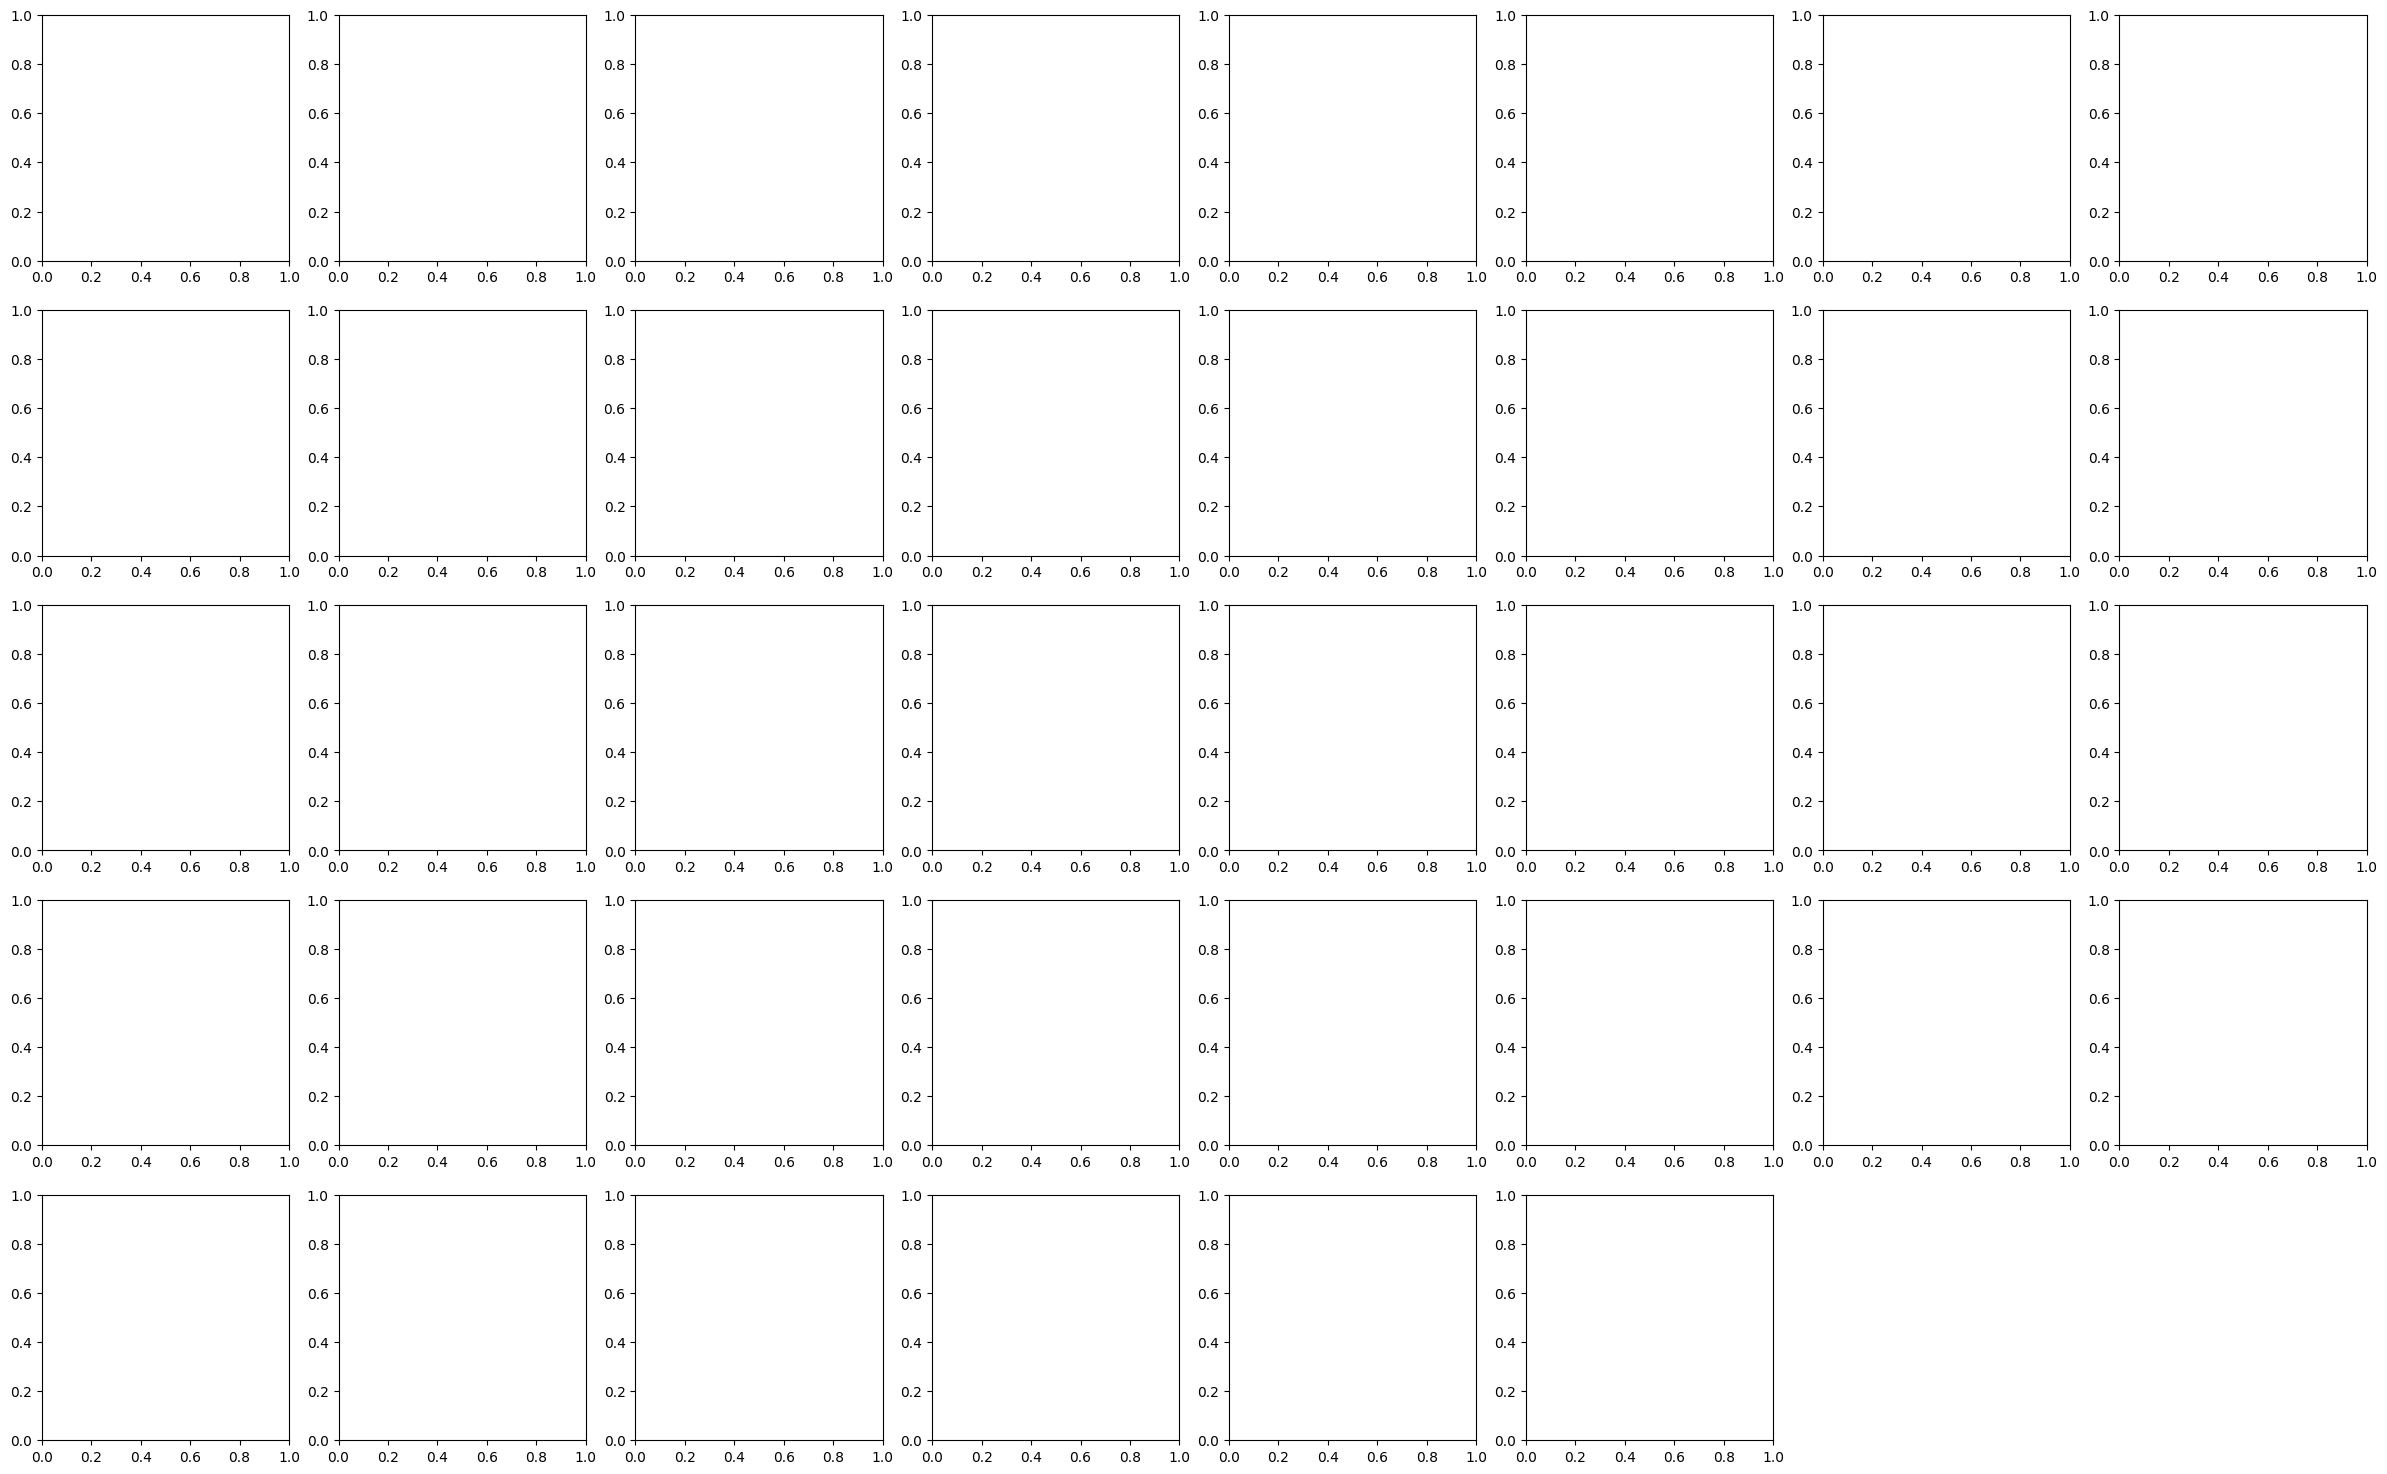

In [4]:
fig, ax = plt.subplots(8, 8, figsize=(30, 30))
col = 0
row = 0
for var in binary_vars:
    if col == 8:
        col = 0
        row += 1
    # create a 4 bar plot where exacerbation is orange and non-exacerbation blue
    exa_and_0 = harvard[(harvard['Exacerbation'] == 1) & (harvard[var] == 0)].shape[0]
    exa_and_1 = harvard[(harvard['Exacerbation'] == 1) & (harvard[var] == 1)].shape[0]
    non_exa_and_0 = harvard[(harvard['Exacerbation'] == 0) & (harvard[var] == 0)].shape[0]
    non_exa_and_1 = harvard[(harvard['Exacerbation'] == 0) & (harvard[var] == 1)].shape[0]
    
    ax[row, col].bar([0, 1], [non_exa_and_0, non_exa_and_1], color='#1f77b4', label='No exacerbation')
    # leave a gap between the bars and then the next set of bars
    ax[row, col].bar([0.2, 1.2], [exa_and_0, exa_and_1], color='#ff7f0e', label='Exacerbation')
    ax[row, col].set_title(var)
    ax[row, col].set_xticklabels(["", 'No', "", "Yes"], rotation=0)
    # add a label onto the middle of the bars

    # if the bar is larger than 10% of the plot height, write the number inside the bar
    # get the max of the 4 bars
    chart_height = np.max([non_exa_and_0, non_exa_and_1, exa_and_0, exa_and_1])

    if non_exa_and_0 > 0.1 * chart_height:
        ax[row, col].text(0.1, non_exa_and_0/2, non_exa_and_0, color='white', fontweight='bold', ha='center', va='center')
    else:
        ax[row, col].text(0.1, non_exa_and_0/2, non_exa_and_0, color='black', fontweight='bold', ha='center', va='center')
    if non_exa_and_1 > 0.1 * chart_height:
        ax[row, col].text(1.1, non_exa_and_1/2, non_exa_and_1, color='white', fontweight='bold', ha='center', va='center')
    else:
        ax[row, col].text(1.1, non_exa_and_1/2, non_exa_and_1, color='black', fontweight='bold', ha='center', va='center')
    if exa_and_0 > 0.1 * chart_height:
        ax[row, col].text(0.3, exa_and_0/2, exa_and_0, color='white', fontweight='bold', ha='center', va='center')
    else:
        ax[row, col].text(0.3, exa_and_0/2, exa_and_0, color='black', fontweight='bold', ha='center', va='center')
    if exa_and_1 > 0.1 * chart_height:
        ax[row, col].text(1.3, exa_and_1/2, exa_and_1, color='white', fontweight='bold', ha='center', va='center')
    else:
        ax[row, col].text(1.3, exa_and_1/2, exa_and_1, color='black', fontweight='bold', ha='center', va='center')
    ax[row, col].legend()
    col += 1

plt.tight_layout()
# save svg
plt.savefig('./results/binary_vars_harvard.svg', format='svg', dpi=1200)

## Matthews Correlation

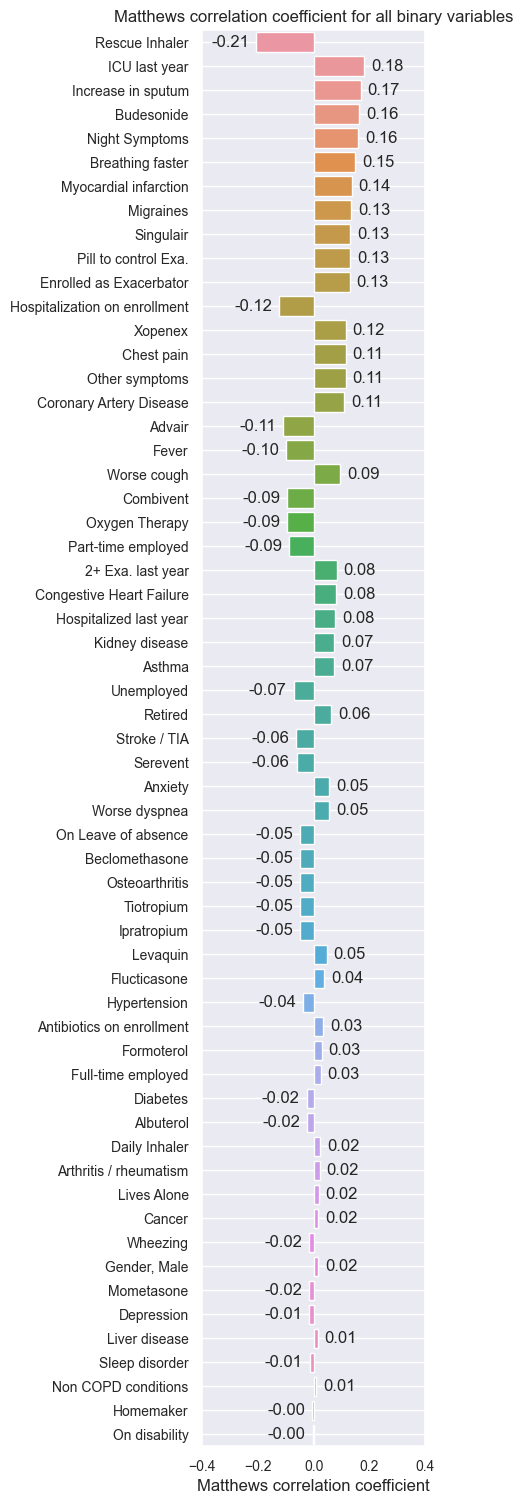

In [60]:
# calculate matthews correlation coefficient for binary variables
from sklearn.metrics import matthews_corrcoef
mcc = []
harvard_binary = harvard.copy()
harvard_binary = harvard_binary.fillna(harvard_binary.mode().iloc[0])

for var in sorted(binary_vars):
    mcc.append(matthews_corrcoef(harvard_binary[var], harvard_binary['Exacerbation']))

sns.set_theme()

# create a dataframe
mcc_df = pd.DataFrame({'Variable': binary_vars, 'MCC': mcc})
# sort by absolute value of mcc
mcc_df = mcc_df.reindex(mcc_df['MCC'].abs().sort_values(ascending=False).index)

# plot mcc
plt.figure(figsize=(5, 15))

# use sns to create a horizontal bar plot with value as text, add a grid line at each values
ax = sns.barplot(x=mcc_df['MCC'], y=mcc_df['Variable'], orient='h')
ax.grid(False, axis='x')
ax.grid(True, axis='y')
# show bar values for all bar with a dash between 
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge', padding=5)
ax.set_xlim(-0.4, 0.4)
# 
# tight layout
plt.tight_layout()

plt.title('Matthews correlation coefficient for all binary variables')
plt.xlabel('Matthews correlation coefficient')
plt.ylabel('')
# increase font size
plt.tick_params(axis='both', which='major', labelsize=10)

# save as svg to results folder
plt.savefig('./results/mcc_binary.svg', format='svg')

## Plot categorical vars

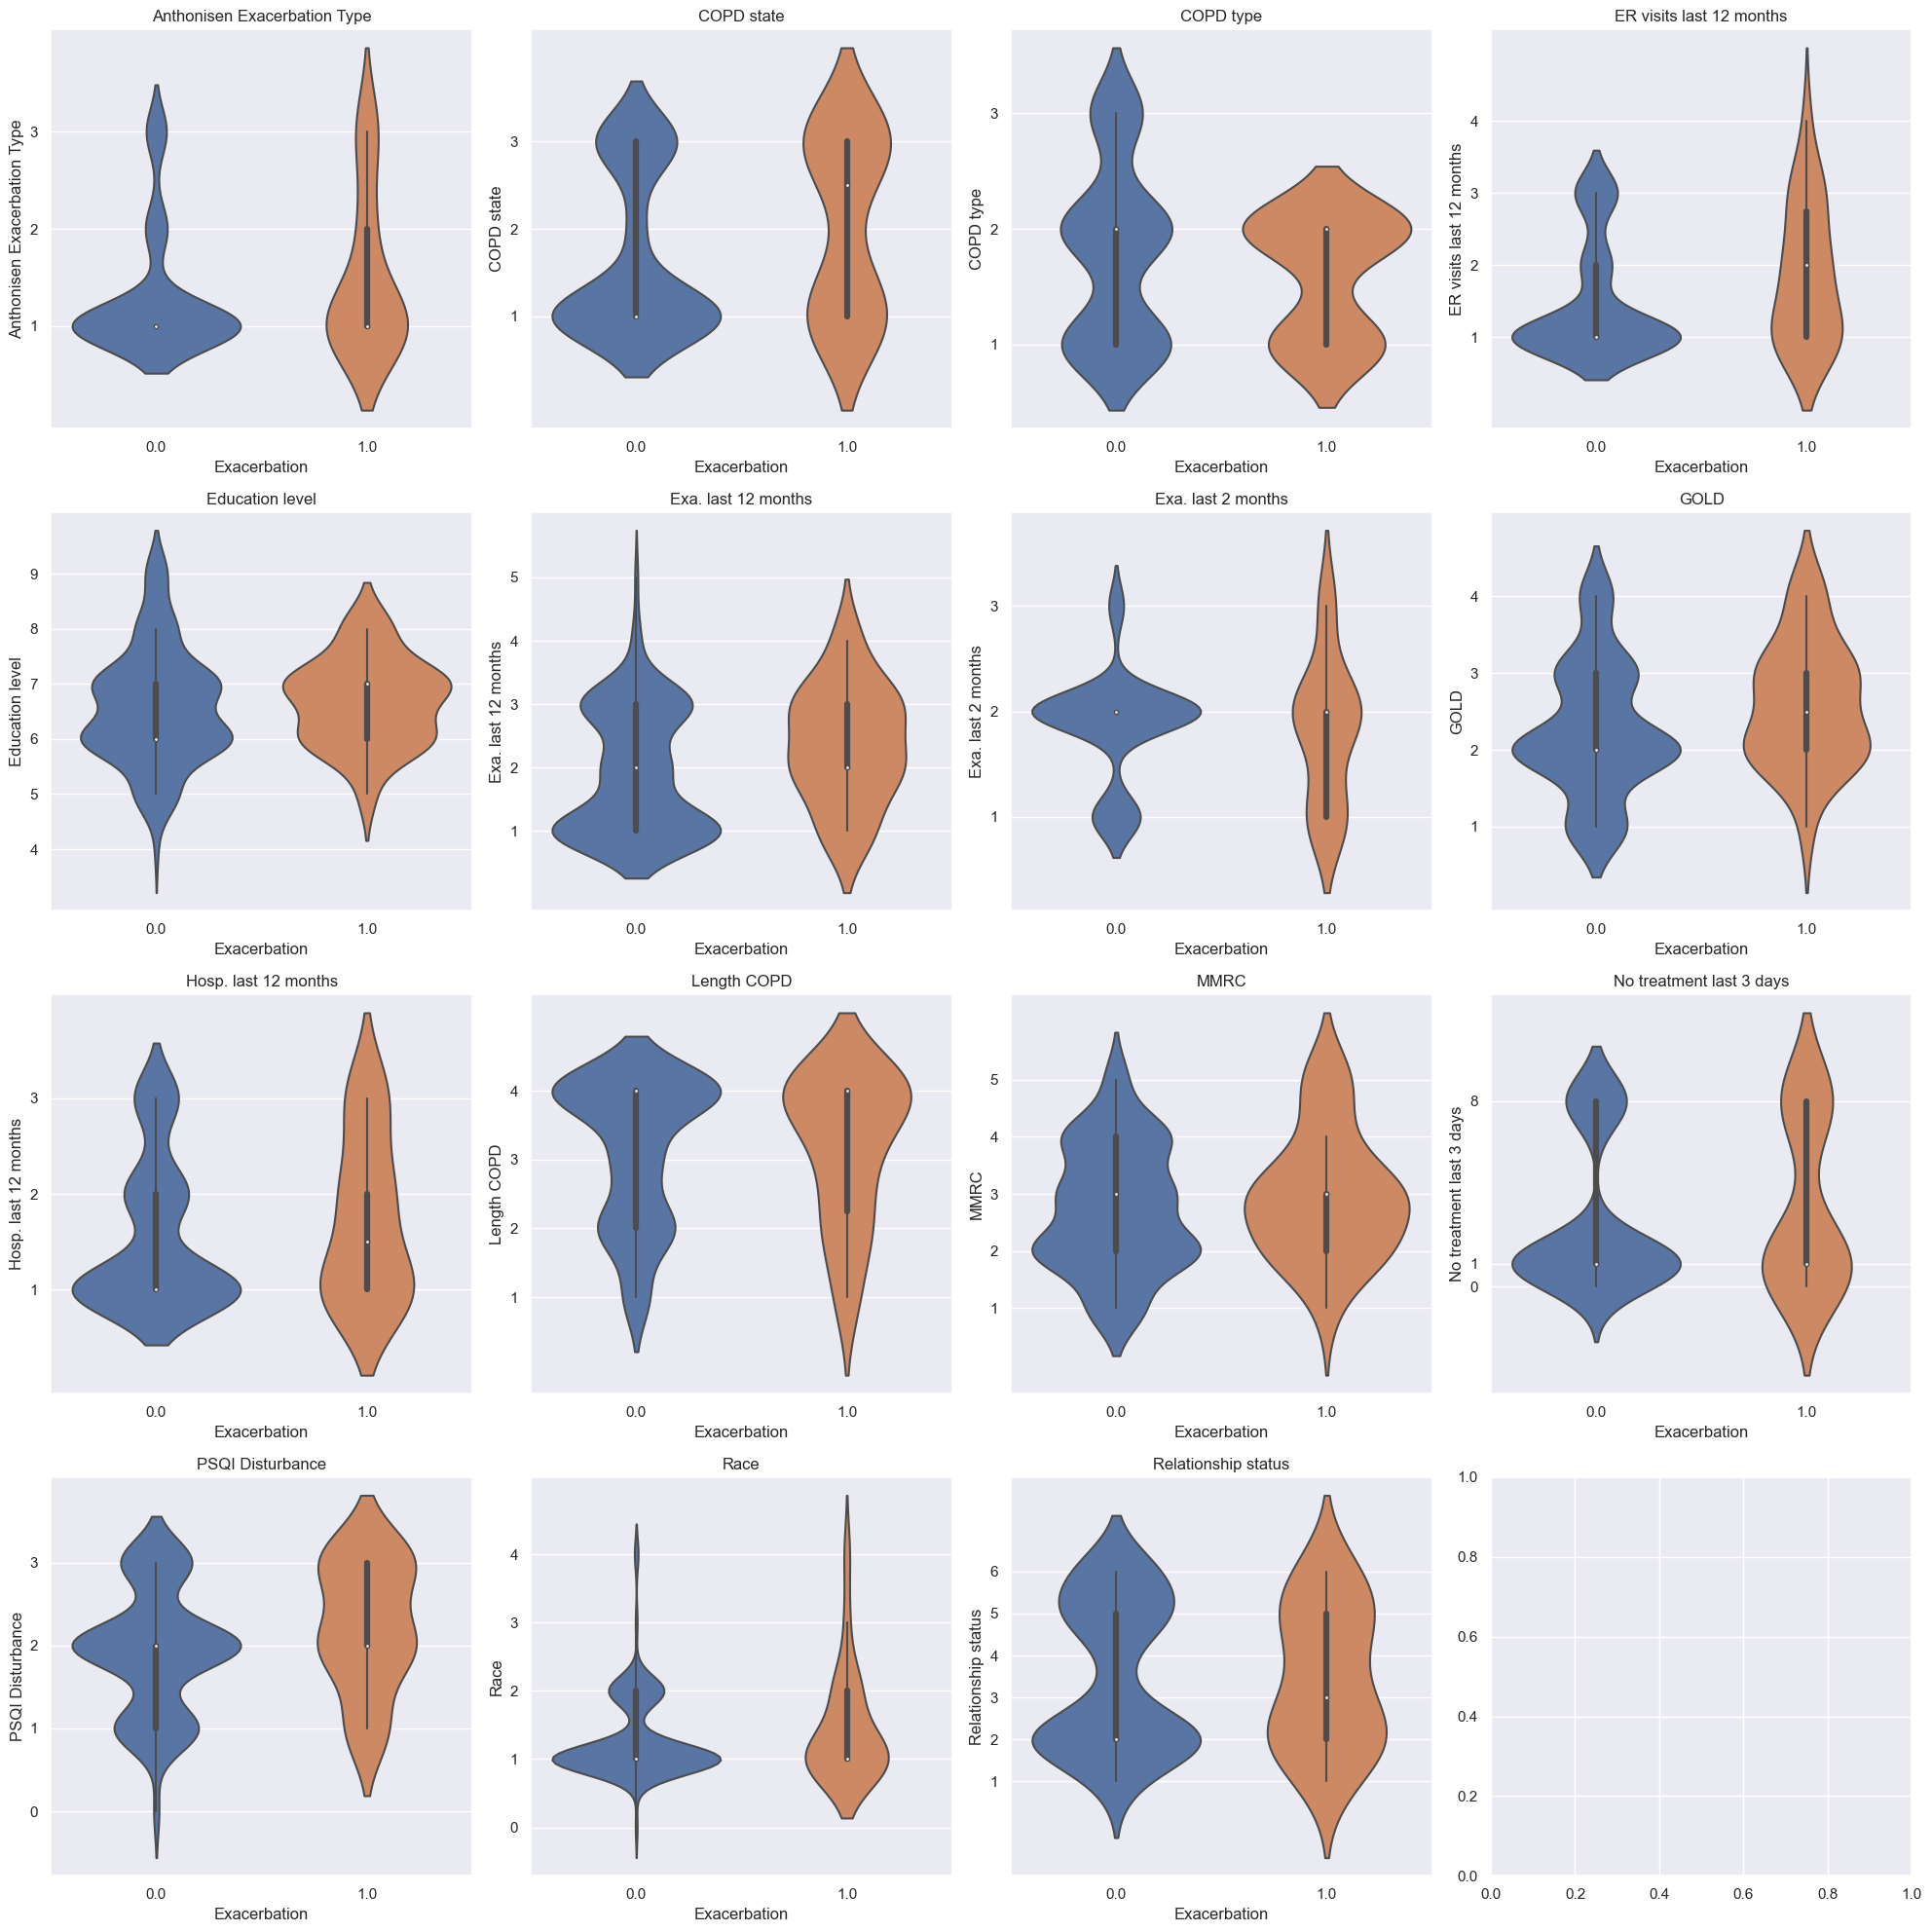

In [61]:
# plot all categorical vars vs target
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
col = 0
row = 0
harvard_viz = harvard.copy()
# drop all rows with nan values
harvard_viz[categorical_vars] = harvard_viz[categorical_vars].fillna(harvard_viz[categorical_vars].mode().iloc[0])
for var in categorical_vars:
    # do not consider nan values 
    if col == 4:
        col = 0
        row += 1
    # plot a line between mean value for exacerbation and non-exacerbation
    sns.violinplot(x='Exacerbation', y=var, data=harvard_viz, ax=axs[row, col])
    axs[row, col].set_title(var)
    axs[row, col].set_yticks(harvard_viz[var].unique())
    axs[row, col].set_ylabel(var)
    axs[row, col].set_xlabel('Exacerbation')
    col += 1

plt.tight_layout()

## Cramer's V

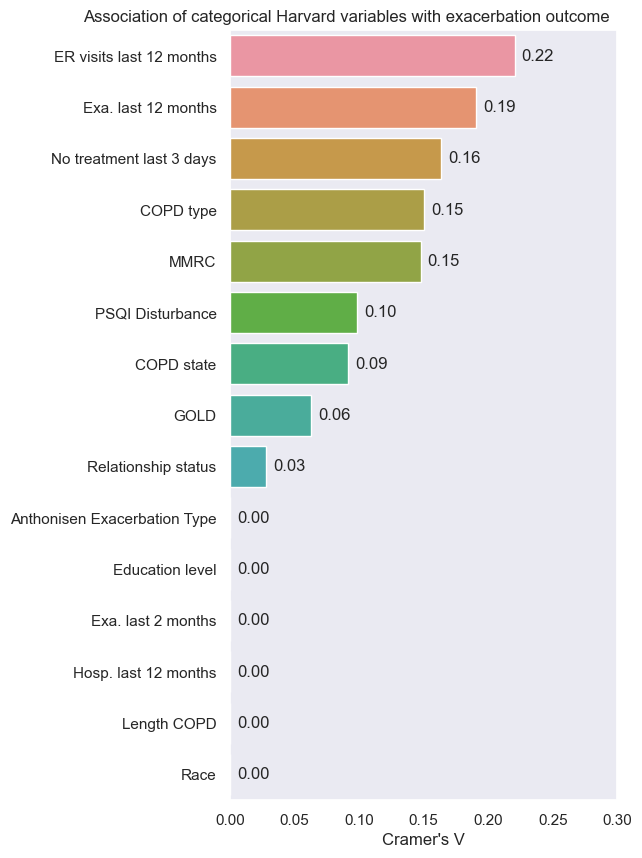

In [62]:
# calculate Cramer's V for all categorical variables
from scipy.stats import chi2_contingency

# calculate Cramer's V between the target (Exacerbation) and all categorical variables
cramers_v = []
harvard_categorical = harvard[categorical_vars].copy()
for var in categorical_vars:
    # calculate contingency table
    contingency_table = pd.crosstab(harvard_categorical[var], harvard['Exacerbation']).to_numpy()
    X2 = chi2_contingency(contingency_table, correction=False)[0]
    n = contingency_table.sum()
    phi2 = X2/n
    r,k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    cramers_v.append(np.sqrt(phi2corr / min((kcorr-1), (rcorr-1))))

# sort by absolute value of cramers_v
cramers_v = pd.DataFrame({'Variable': categorical_vars, 'Cramers_V': cramers_v})
cramers_v = cramers_v.reindex(cramers_v['Cramers_V'].abs().sort_values(ascending=False).index)
sns.set_style()
# plot Cramer's V for all categorical variables
fig, ax = plt.subplots(figsize=(5, 10))
ax = sns.barplot(x=cramers_v['Cramers_V'], y=cramers_v['Variable'], orient='h')
ax.grid(False, axis='x')
# add values to the bars
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge', padding=5)
# set x axis limits
ax.set_xlim(0, 0.3)
plt.title("Association of categorical Harvard variables with exacerbation outcome")
# center the title
ax.title.set_position([0.3, 1.05])
plt.xlabel("Cramer's V")
plt.ylabel("")

# save as svg to results folder
plt.savefig('./results/cramers_v.svg', format='svg')

## Plot continuous vars

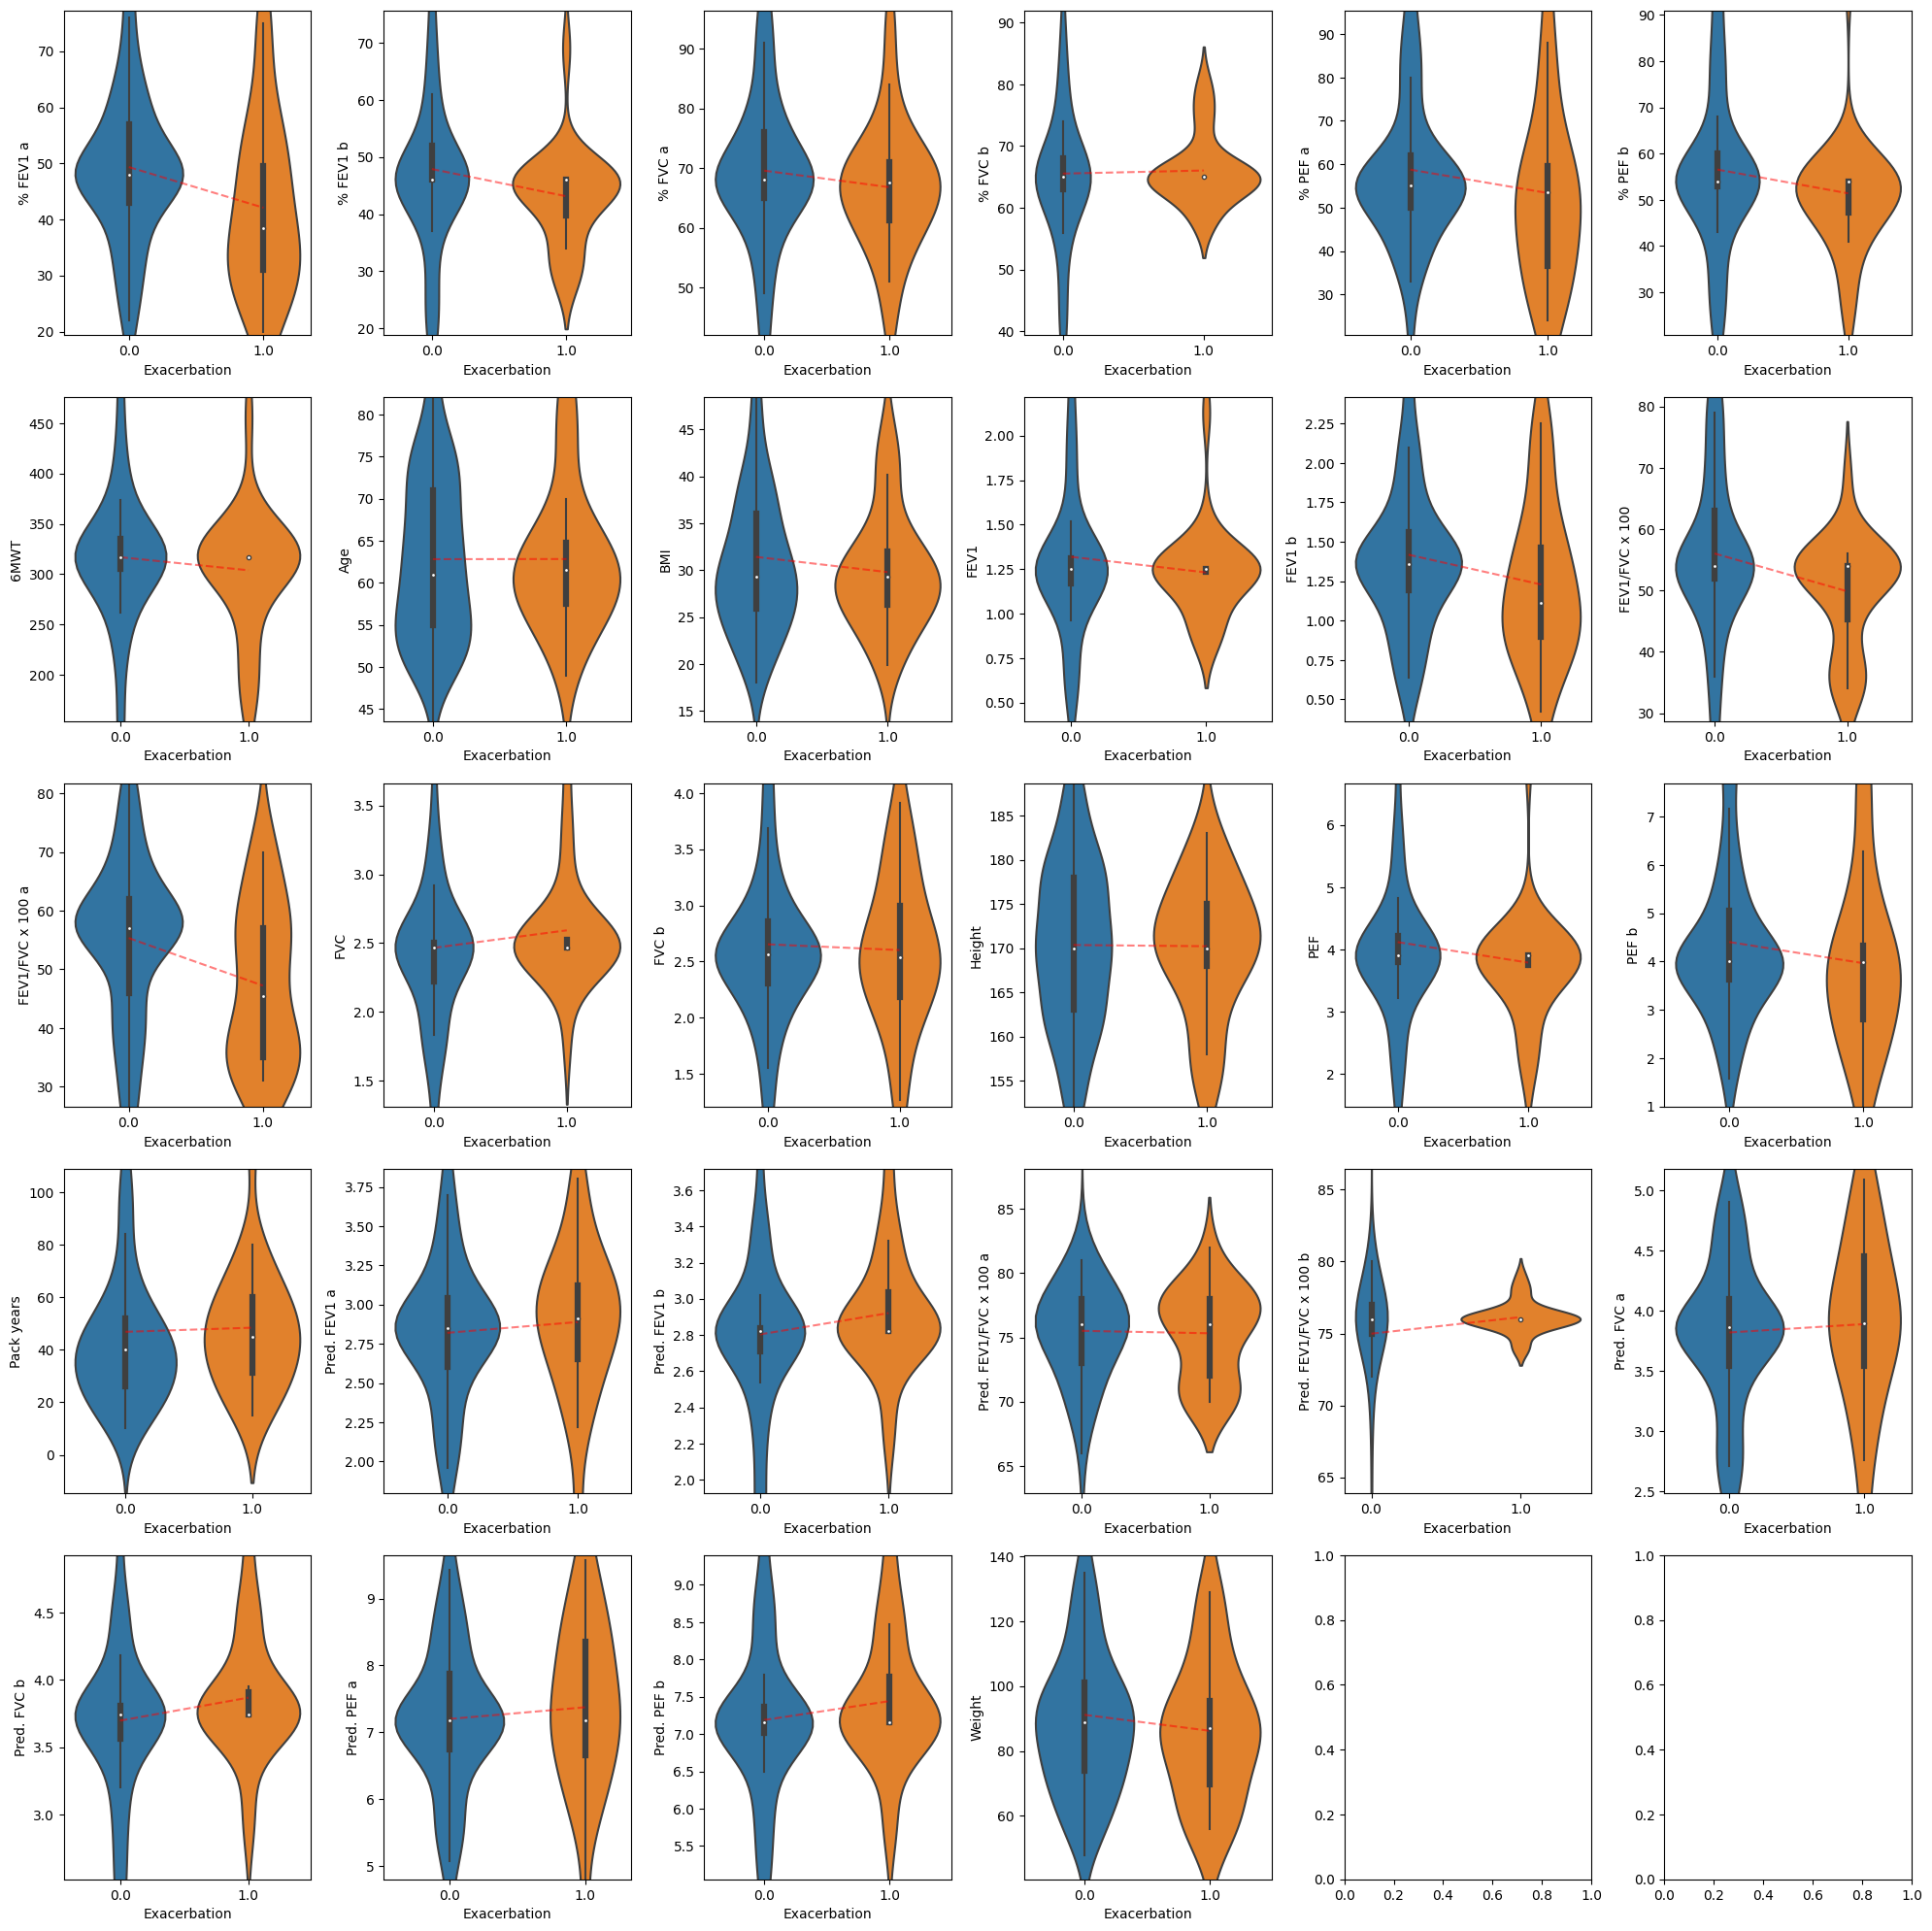

In [45]:
import seaborn as sns
# plot all continuous vars vs target
fig, axs = plt.subplots(5, 6, figsize=(20, 20))
col = 0
row = 0
harvard_viz = harvard.copy()
harvard_viz[continuous_vars] = harvard_viz[continuous_vars].fillna(harvard_viz[continuous_vars].median())
for var in continuous_vars:
    if col == 6:
        col = 0
        row += 1
    # plot a violin plot for exacerbation at x=1 and one for no exacerbation at x=0
    sns.violinplot(x='Exacerbation', y=var, data=harvard_viz, ax=axs[row, col])
    # move the y axis so that the mean value of the non-exacerbators is in the center
    axs[row, col].set_ylim(harvard_viz[var].mean() - 2 * harvard_viz[var].std(), harvard_viz[var].mean() + 2 * harvard_viz[var].std())
    # draw a line between the median values at 1 and the median values at 0
    axs[row, col].plot([0, 1], [harvard_viz[harvard_viz['Exacerbation'] == 0][var].mean(), harvard_viz[harvard_viz['Exacerbation'] == 1][var].mean()], color='red', alpha=0.5, linestyle='--')
    axs[row, col].set_xlabel('Exacerbation')
    axs[row, col].set_xticks([0, 1])
    axs[row, col].set_ylabel(var)
    col += 1

plt.tight_layout()
# save as svg to results folder
plt.savefig('./results/point_biserial_vis.svg', format='svg')

## Point Biserial Correlation

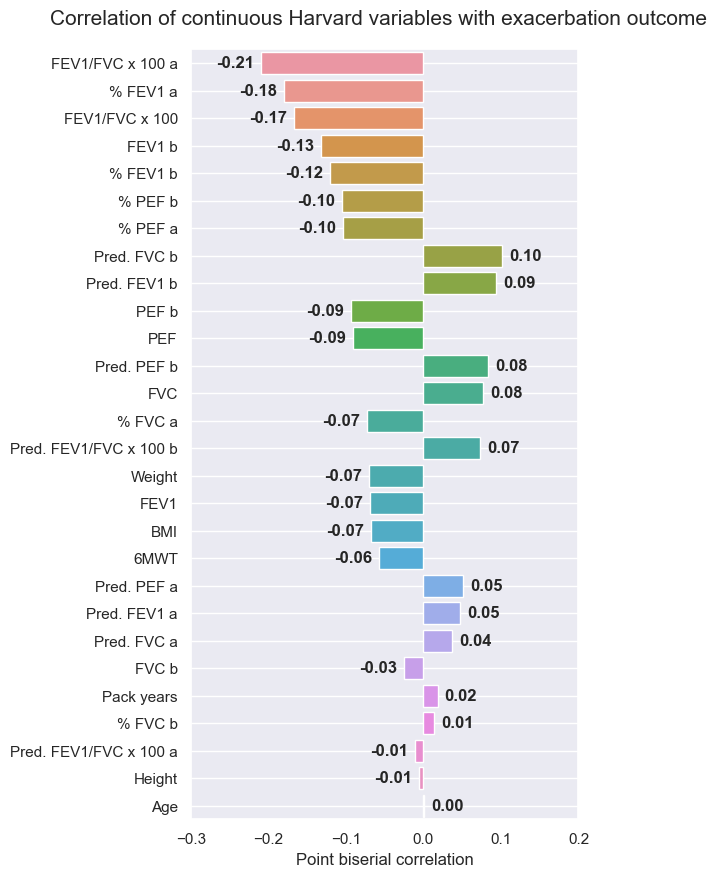

In [64]:
from scipy.stats import pointbiserialr
# calculate point biserial correlation for continuous variables
biserial_corr = []
harvard_continuous = harvard[continuous_vars].copy()
for var in continuous_vars:
    # drop all rows with nan values
    harvard_continuous[var] = harvard_continuous[var].fillna(harvard_continuous[var].median())
    # calculate point biserial correlation
    biserial_corr.append(pointbiserialr(harvard_continuous[var], harvard['Exacerbation'])[0])

# create a dataframe
biserial_corr = pd.DataFrame({'Variable': continuous_vars, 'Point biserial correlation': biserial_corr})
# sort by absolute value of point biserial correlation
biserial_corr = biserial_corr.reindex(biserial_corr['Point biserial correlation'].abs().sort_values(ascending=False).index)

sns.set_style()
# plot point biserial correlation for all continuous variables
fig, ax = plt.subplots(figsize=(5, 10))
ax = sns.barplot(x=biserial_corr['Point biserial correlation'], y=biserial_corr['Variable'], orient='h')
ax.grid(False, axis='x')
ax.grid(True, axis='y')
# add values to the bars
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge', padding=5, fontweight='bold')
# set x axis limits
ax.set_xlim(-0.3, 0.2)
    

# ax.title('Correlation of continuous Harvard variables with exacerbation outcome',  pad=10, fontsize=15)
fig.suptitle('Correlation of continuous Harvard variables with exacerbation outcome', fontsize=15, y=0.92)
# remove y label
ax.set_ylabel('')
    
plt.xlabel('Point biserial correlation')
# set y ticks to fontweight bold
# ax.set_yticklabels(ax.get_yticklabels(), fontweight='bold')
# save as svg to results folder
plt.savefig('./results/point_biserial.svg', format='svg')

# Descriptive Statistics Harvard

In [16]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
import statsmodels.api as sm

# binary columns are variables with only 2 values
binary_cols = harvard.columns[harvard.nunique() == 2].drop('Exacerbation')
count_dataframe = pd.DataFrame(columns=['Exacerbation', 'No Exacerbation', 'Odds Ratio'])
# add row n with the count of exacerbations
exa_count = harvard['Exacerbation'][harvard['Exacerbation'] == 1].count()
no_exa_count = harvard['Exacerbation'][harvard['Exacerbation'] == 0].count()
count_dataframe.loc['n'] = exa_count, no_exa_count, ""
for var in binary_cols:
    # the Exacerbation column is all values where fclinra08 is 1 and the value in col is the positive value
    exa_col_count = [harvard['Exacerbation'][harvard['Exacerbation'] == 1][harvard[var] == 1].count()]
    exa_percentage = round(exa_col_count[0] / exa_count * 100, 2)
    exa_col_string = str(exa_col_count[0]) + ' (' + str(exa_percentage) + '%)'
    no_exa_col_count = [harvard['Exacerbation'][harvard['Exacerbation'] == 0][harvard[var] == 1].count()]
    no_exa_percentage = round(no_exa_col_count[0] / no_exa_count * 100, 2)
    no_exa_col_string = str(no_exa_col_count[0]) + ' (' + str(no_exa_percentage) + '%)'
    # fit a logistic model to calculate the odds ratio
    X = harvard[var]
    # drop all rows with nan values
    X = X[~np.isnan(X)]
    y = harvard['Exacerbation']
    y = y[X.index]
    X = X.values.reshape(-1, 1)
    y = LabelEncoder().fit_transform(y)
    # calculate odds ratio for this variable using stats model
    sm_model = sm.Logit(y, sm.add_constant(X)).fit(disp=False)
    # get 95% CI for odds ratio
    ci = sm_model.conf_int(alpha=0.05, cols=None)
    # calculate odds ratio
    odds_ratio = np.exp(sm_model.params[1])
    # calculate lower and upper bound of 95% CI
    lower_bound = np.exp(ci[0][1])
    upper_bound = np.exp(ci[1][1])
    # create a string for the odds ratio and 95% CI
    odds_ratio_string = str(round(odds_ratio, 2)) + ' (' + str(round(lower_bound, 2)) + '-' + str(round(upper_bound, 2)) + ')'
    # add the counts to the dataframe
    count_dataframe.loc[var] = exa_col_string, no_exa_col_string, odds_ratio_string

# sort by effect size
count_dataframe.sort_values(by='Odds Ratio', ascending=False, inplace=True)

# now look at numeric variables
numeric_cols = harvard.columns[harvard.nunique() > 2]
mean_dataframe = pd.DataFrame(columns=['Exacerbation', 'No Exacerbation', 'Odds Ratio'])
for var in numeric_cols:
    positives = harvard[var][harvard['Exacerbation'] == 1]
    negatives = harvard[var][harvard['Exacerbation'] == 0]
    # get the mean + std for the exacerbation group with only 2 decimal places
    exacerbation_mean = round([positives.mean()][0], 2)
    exacerbation_std = round([positives.std()][0], 2)
    # create a string for the mean +- std
    exacerbation_string = str(exacerbation_mean) + u"(" + str(exacerbation_std) +")"
    # get the mean + std for the no exacerbation group
    no_exacerbation_mean = round([negatives.mean()][0], 2)
    no_exacerbation_std = round([negatives.std()][0], 2)
    # create a string for the mean +- std
    no_exacerbation_string = str(no_exacerbation_mean) + u"(" + str(no_exacerbation_std) +")"
    std_exa = harvard[var][harvard['Exacerbation'] == 1].std()
    # effect size 1 (Glass's delta) with Exacerbation group variance that we want to emphasize
    #effect_size = np.round((exacerbation_mean - no_exacerbation_mean) / std_exa, 2)
    X = harvard[var]
    # drop all rows with nan values
    X = X[~np.isnan(X)]
    y = harvard['Exacerbation']
    # match the indices of X and y
    y = y[X.index]
    X = X.values.reshape(-1, 1)
    y = LabelEncoder().fit_transform(y)
     # calculate odds ratio for this variable using stats model
    sm_model = sm.Logit(y, sm.add_constant(X)).fit(disp=False)
    ci = sm_model.conf_int(alpha=0.05, cols=None)
    # calculate odds ratio
    odds_ratio = np.exp(sm_model.params[1])
    # calculate lower and upper bound of 95% CI
    lower_bound = np.exp(ci[0][1])
    upper_bound = np.exp(ci[1][1])
    # create a string for the odds ratio and 95% CI
    odds_ratio_string = str(round(odds_ratio, 2)) + ' (' + str(round(lower_bound, 2)) + '-' + str(round(upper_bound, 2)) + ')'

    # add the strings to the dataframe
    mean_dataframe.loc[var] = exacerbation_string, no_exacerbation_string, odds_ratio_string

# sort by effect size
mean_dataframe.sort_values(by='Odds Ratio', ascending=False, inplace=True)

# concat both dataframes
descriptive_stats = pd.concat([count_dataframe, mean_dataframe], axis=0)


# export to csv
descriptive_stats.to_csv('.\harvard_descriptive_stats_2.csv', sep=';', decimal=',', encoding='utf-8')

c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Daniel\AppData\Local\Temp\ipykernel_4648\962331455.py:36: RuntimeWarning: overflow encountered in exp
  lower_bound = np.exp(ci[0][1])
C:\Users\Daniel\AppData\Local\Temp\ipykernel_4648\962331455.py:37: RuntimeWarning: overflow encountered in exp
  upper_bound = np.exp(ci[1][1])
c:\Users\Daniel\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
C:\Users\Daniel\AppData\Local\Temp\ipykernel_4648\962331455.py:37: RuntimeWarning: overflow encountered in exp
  upper_bound = np.exp(ci[1][1])
C:\Users\Daniel\AppData\Local\Temp\ipykernel_4648\962331

# Triage

In [52]:
binary_vars_triage = triage.columns[triage.nunique() == 2].drop('Exacerbation')
categorical_vars_triage = triage.columns[(triage.nunique() > 2) & (triage.nunique() <= 5)]
continuous_vars_triage = triage.columns[triage.nunique() > 5]

## Plot Binary vars

C:\Users\Daniel\AppData\Local\Temp\ipykernel_33520\1354438671.py:18: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[row, col].set_xticklabels(["", 'No', "", "Yes"], rotation=0)


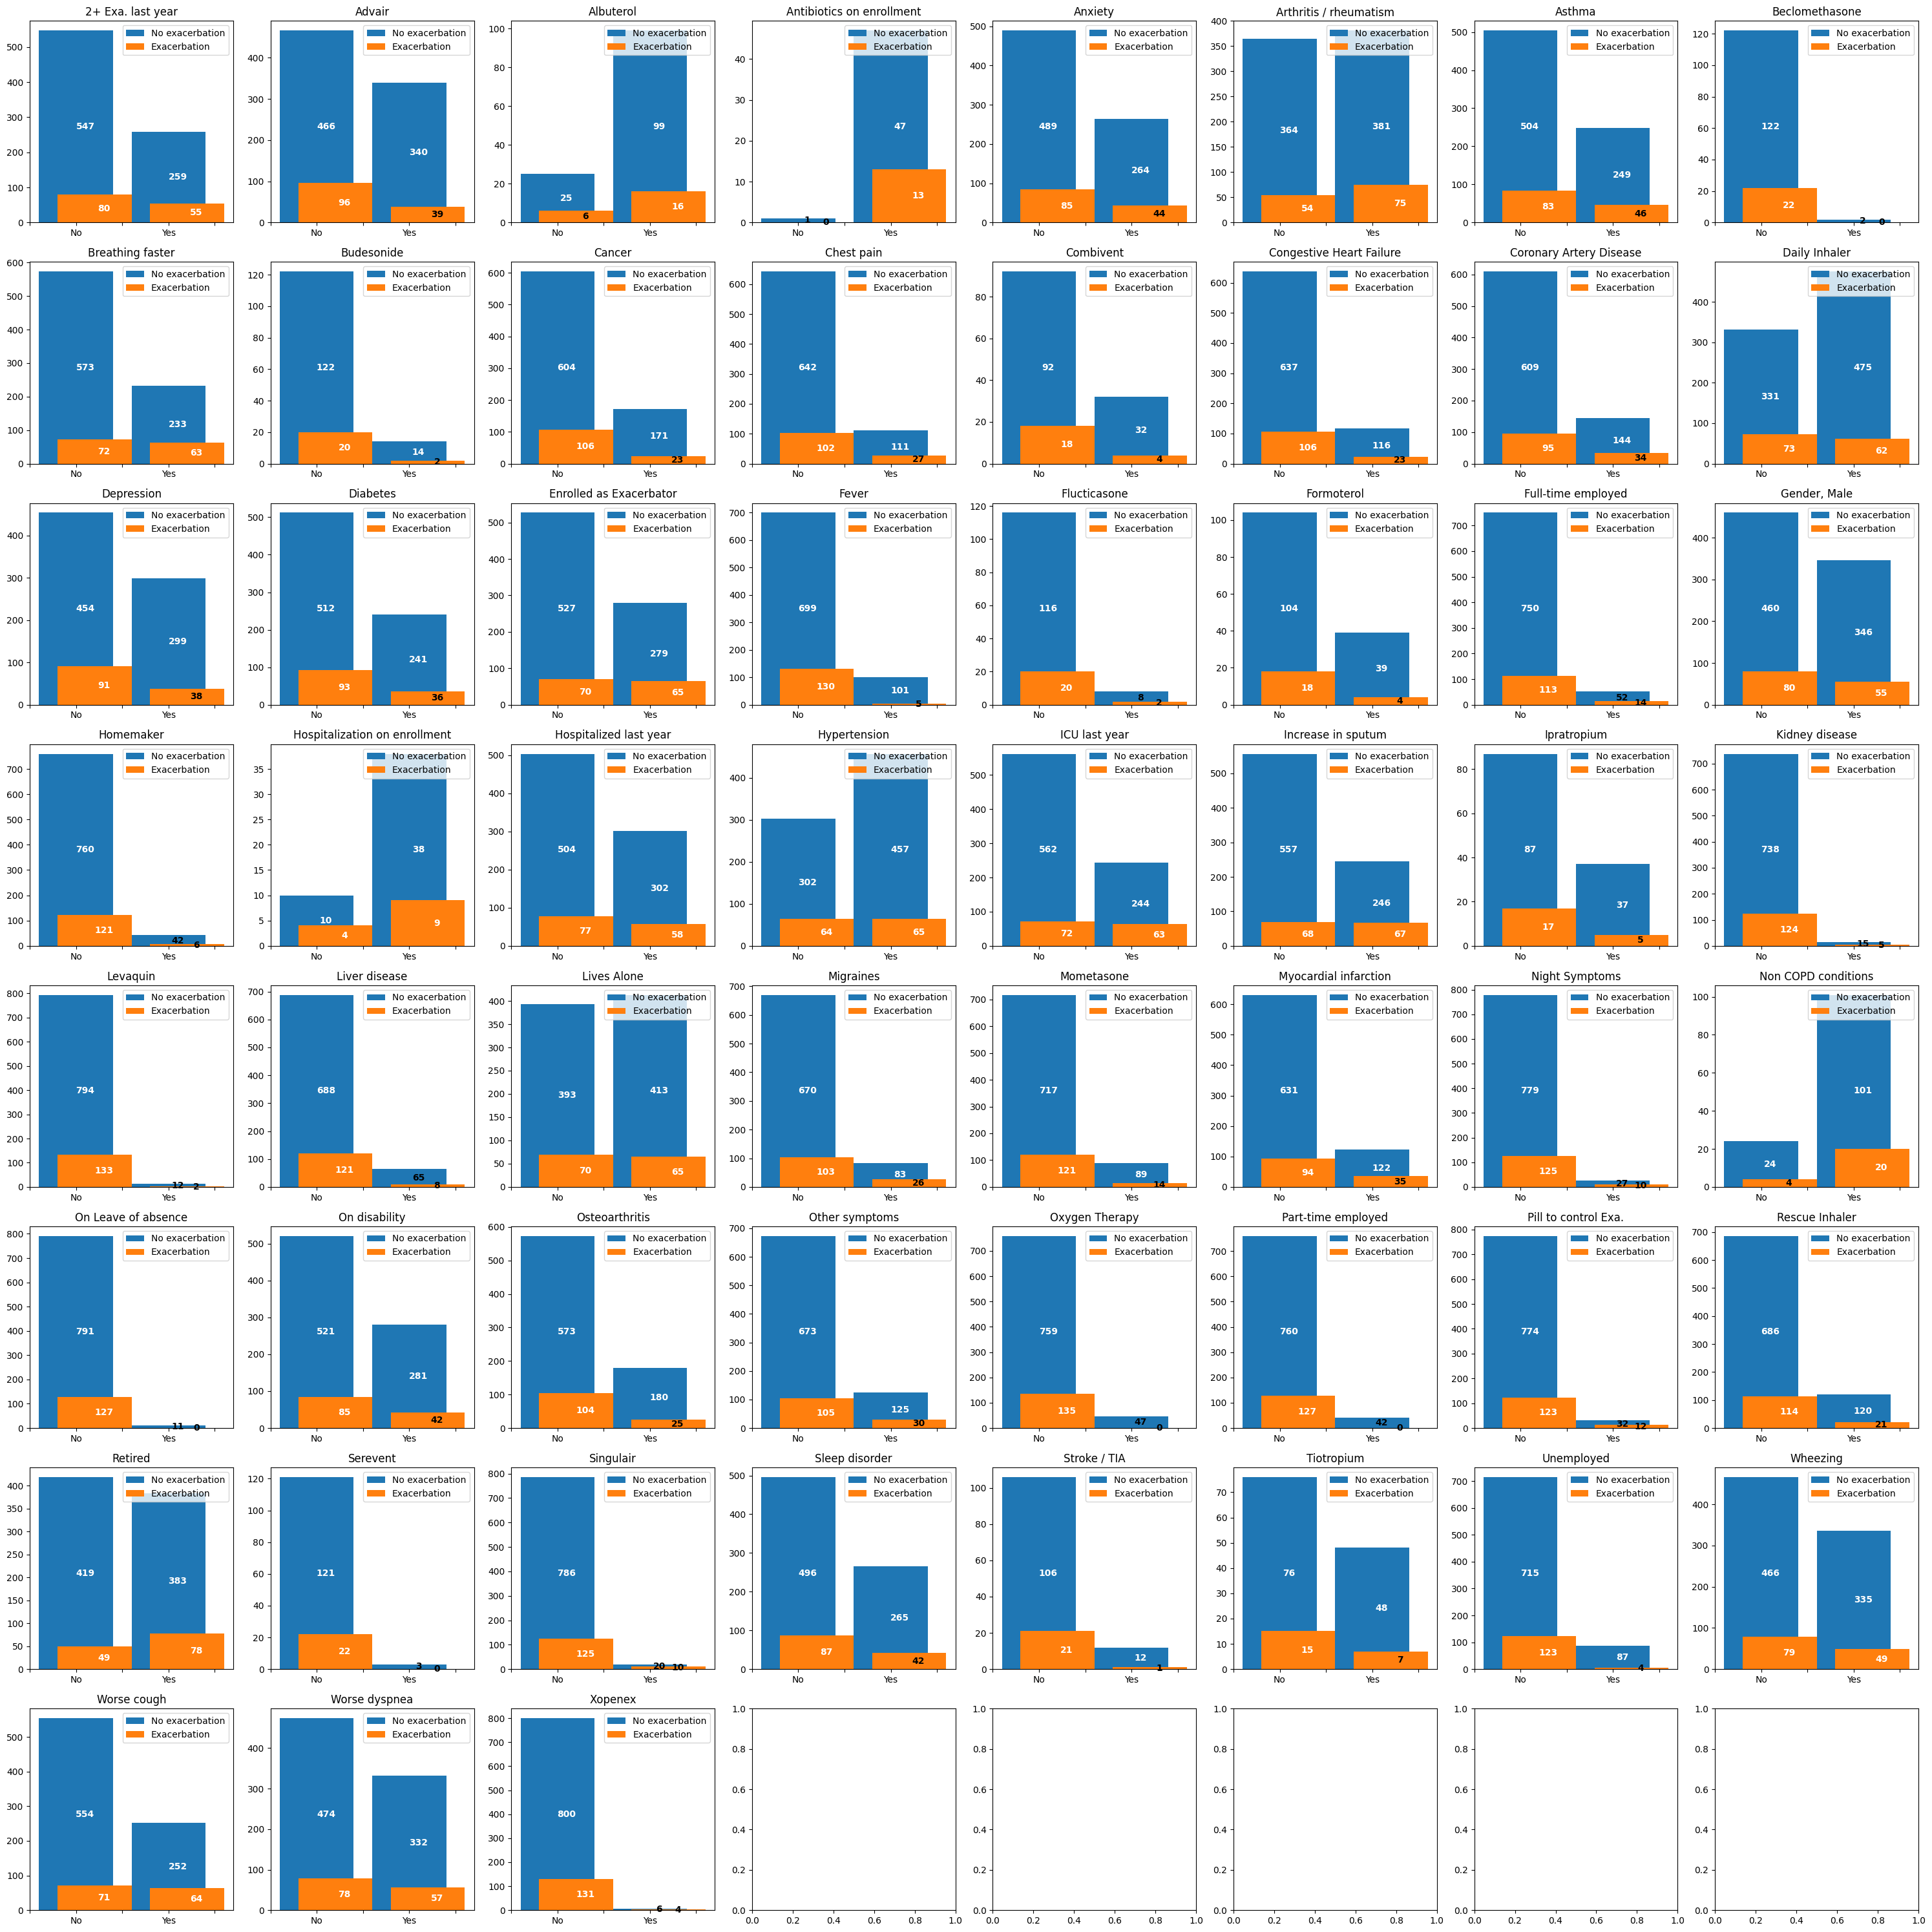

In [12]:
fig, ax = plt.subplots(8, 8, figsize=(30, 30))
col = 0
row = 0
for var in binary_vars:
    if col == 8:
        col = 0
        row += 1
    # create a 4 bar plot where exacerbation is orange and non-exacerbation blue
    exa_and_0 = harvard[(harvard['Exacerbation'] == 1) & (harvard[var] == 0)].shape[0]
    exa_and_1 = harvard[(harvard['Exacerbation'] == 1) & (harvard[var] == 1)].shape[0]
    non_exa_and_0 = harvard[(harvard['Exacerbation'] == 0) & (harvard[var] == 0)].shape[0]
    non_exa_and_1 = harvard[(harvard['Exacerbation'] == 0) & (harvard[var] == 1)].shape[0]
    
    ax[row, col].bar([0, 1], [non_exa_and_0, non_exa_and_1], color='#1f77b4', label='No exacerbation')
    # leave a gap between the bars and then the next set of bars
    ax[row, col].bar([0.2, 1.2], [exa_and_0, exa_and_1], color='#ff7f0e', label='Exacerbation')
    ax[row, col].set_title(var)
    ax[row, col].set_xticklabels(["", 'No', "", "Yes"], rotation=0)
    # add a label onto the middle of the bars

    # if the bar is larger than 10% of the plot height, write the number inside the bar
    # get the max of the 4 bars
    chart_height = np.max([non_exa_and_0, non_exa_and_1, exa_and_0, exa_and_1])

    if non_exa_and_0 > 0.1 * chart_height:
        ax[row, col].text(0.1, non_exa_and_0/2, non_exa_and_0, color='white', fontweight='bold', ha='center', va='center')
    else:
        ax[row, col].text(0.1, non_exa_and_0/2, non_exa_and_0, color='black', fontweight='bold', ha='center', va='center')
    if non_exa_and_1 > 0.1 * chart_height:
        ax[row, col].text(1.1, non_exa_and_1/2, non_exa_and_1, color='white', fontweight='bold', ha='center', va='center')
    else:
        ax[row, col].text(1.1, non_exa_and_1/2, non_exa_and_1, color='black', fontweight='bold', ha='center', va='center')
    if exa_and_0 > 0.1 * chart_height:
        ax[row, col].text(0.3, exa_and_0/2, exa_and_0, color='white', fontweight='bold', ha='center', va='center')
    else:
        ax[row, col].text(0.3, exa_and_0/2, exa_and_0, color='black', fontweight='bold', ha='center', va='center')
    if exa_and_1 > 0.1 * chart_height:
        ax[row, col].text(1.3, exa_and_1/2, exa_and_1, color='white', fontweight='bold', ha='center', va='center')
    else:
        ax[row, col].text(1.3, exa_and_1/2, exa_and_1, color='black', fontweight='bold', ha='center', va='center')
    ax[row, col].legend()
    col += 1

plt.tight_layout()
# save svg
plt.savefig('./results/binary_vars_harvard.svg', format='svg', dpi=1200)

## Matthews Correlation Coefficient

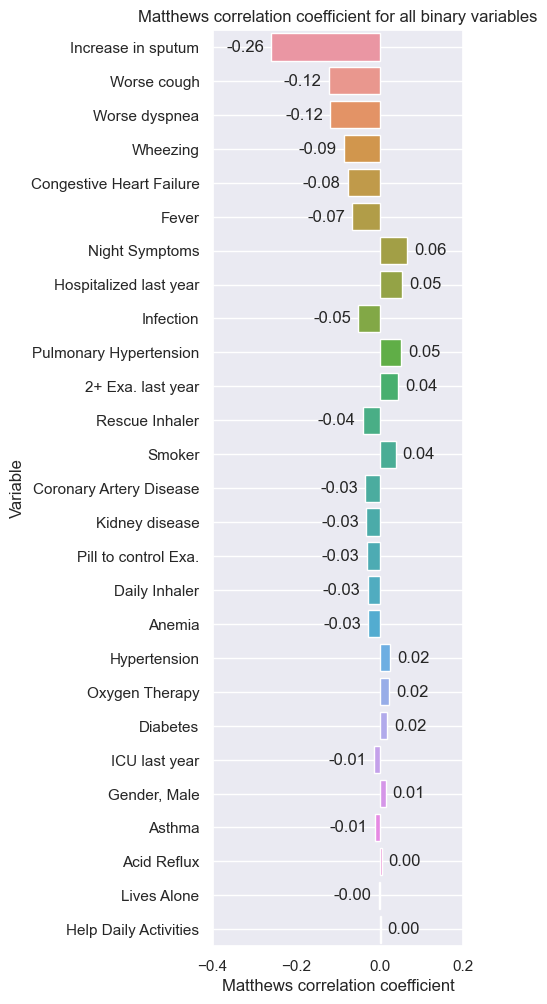

In [69]:
# calculate matthews correlation coefficient for binary variables
from sklearn.metrics import matthews_corrcoef
mcc = []
triage_binary = triage.copy()
triage_binary = triage_binary.fillna(triage_binary.mode().iloc[0])

for var in sorted(binary_vars_triage):
    mcc.append(matthews_corrcoef(triage_binary[var], triage_binary['Exacerbation']))

# create a dataframe
mcc_df = pd.DataFrame({'Variable': binary_vars_triage, 'MCC': mcc})
# sort by absolute value of mcc
mcc_df = mcc_df.reindex(mcc_df['MCC'].abs().sort_values(ascending=False).index)
# plot mcc
fig, ax = plt.subplots(figsize=(5, 10))
# use sns to create a horizontal bar plot with value as text, add a grid line at each values
ax = sns.barplot(x=mcc_df['MCC'], y=mcc_df['Variable'], orient='h')
ax.grid(False, axis='x')
ax.grid(True, axis='y')
# show bar values for all bar with a dash between
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge', padding=5)
ax.set_xlim(-0.4, 0.2)

plt.tight_layout()
plt.title('Matthews correlation coefficient for all binary variables')
plt.xlabel('Matthews correlation coefficient')

# save as svg to results folder
plt.savefig('./results/mcc_binary_triage.svg', format='svg')

## Plot categorical

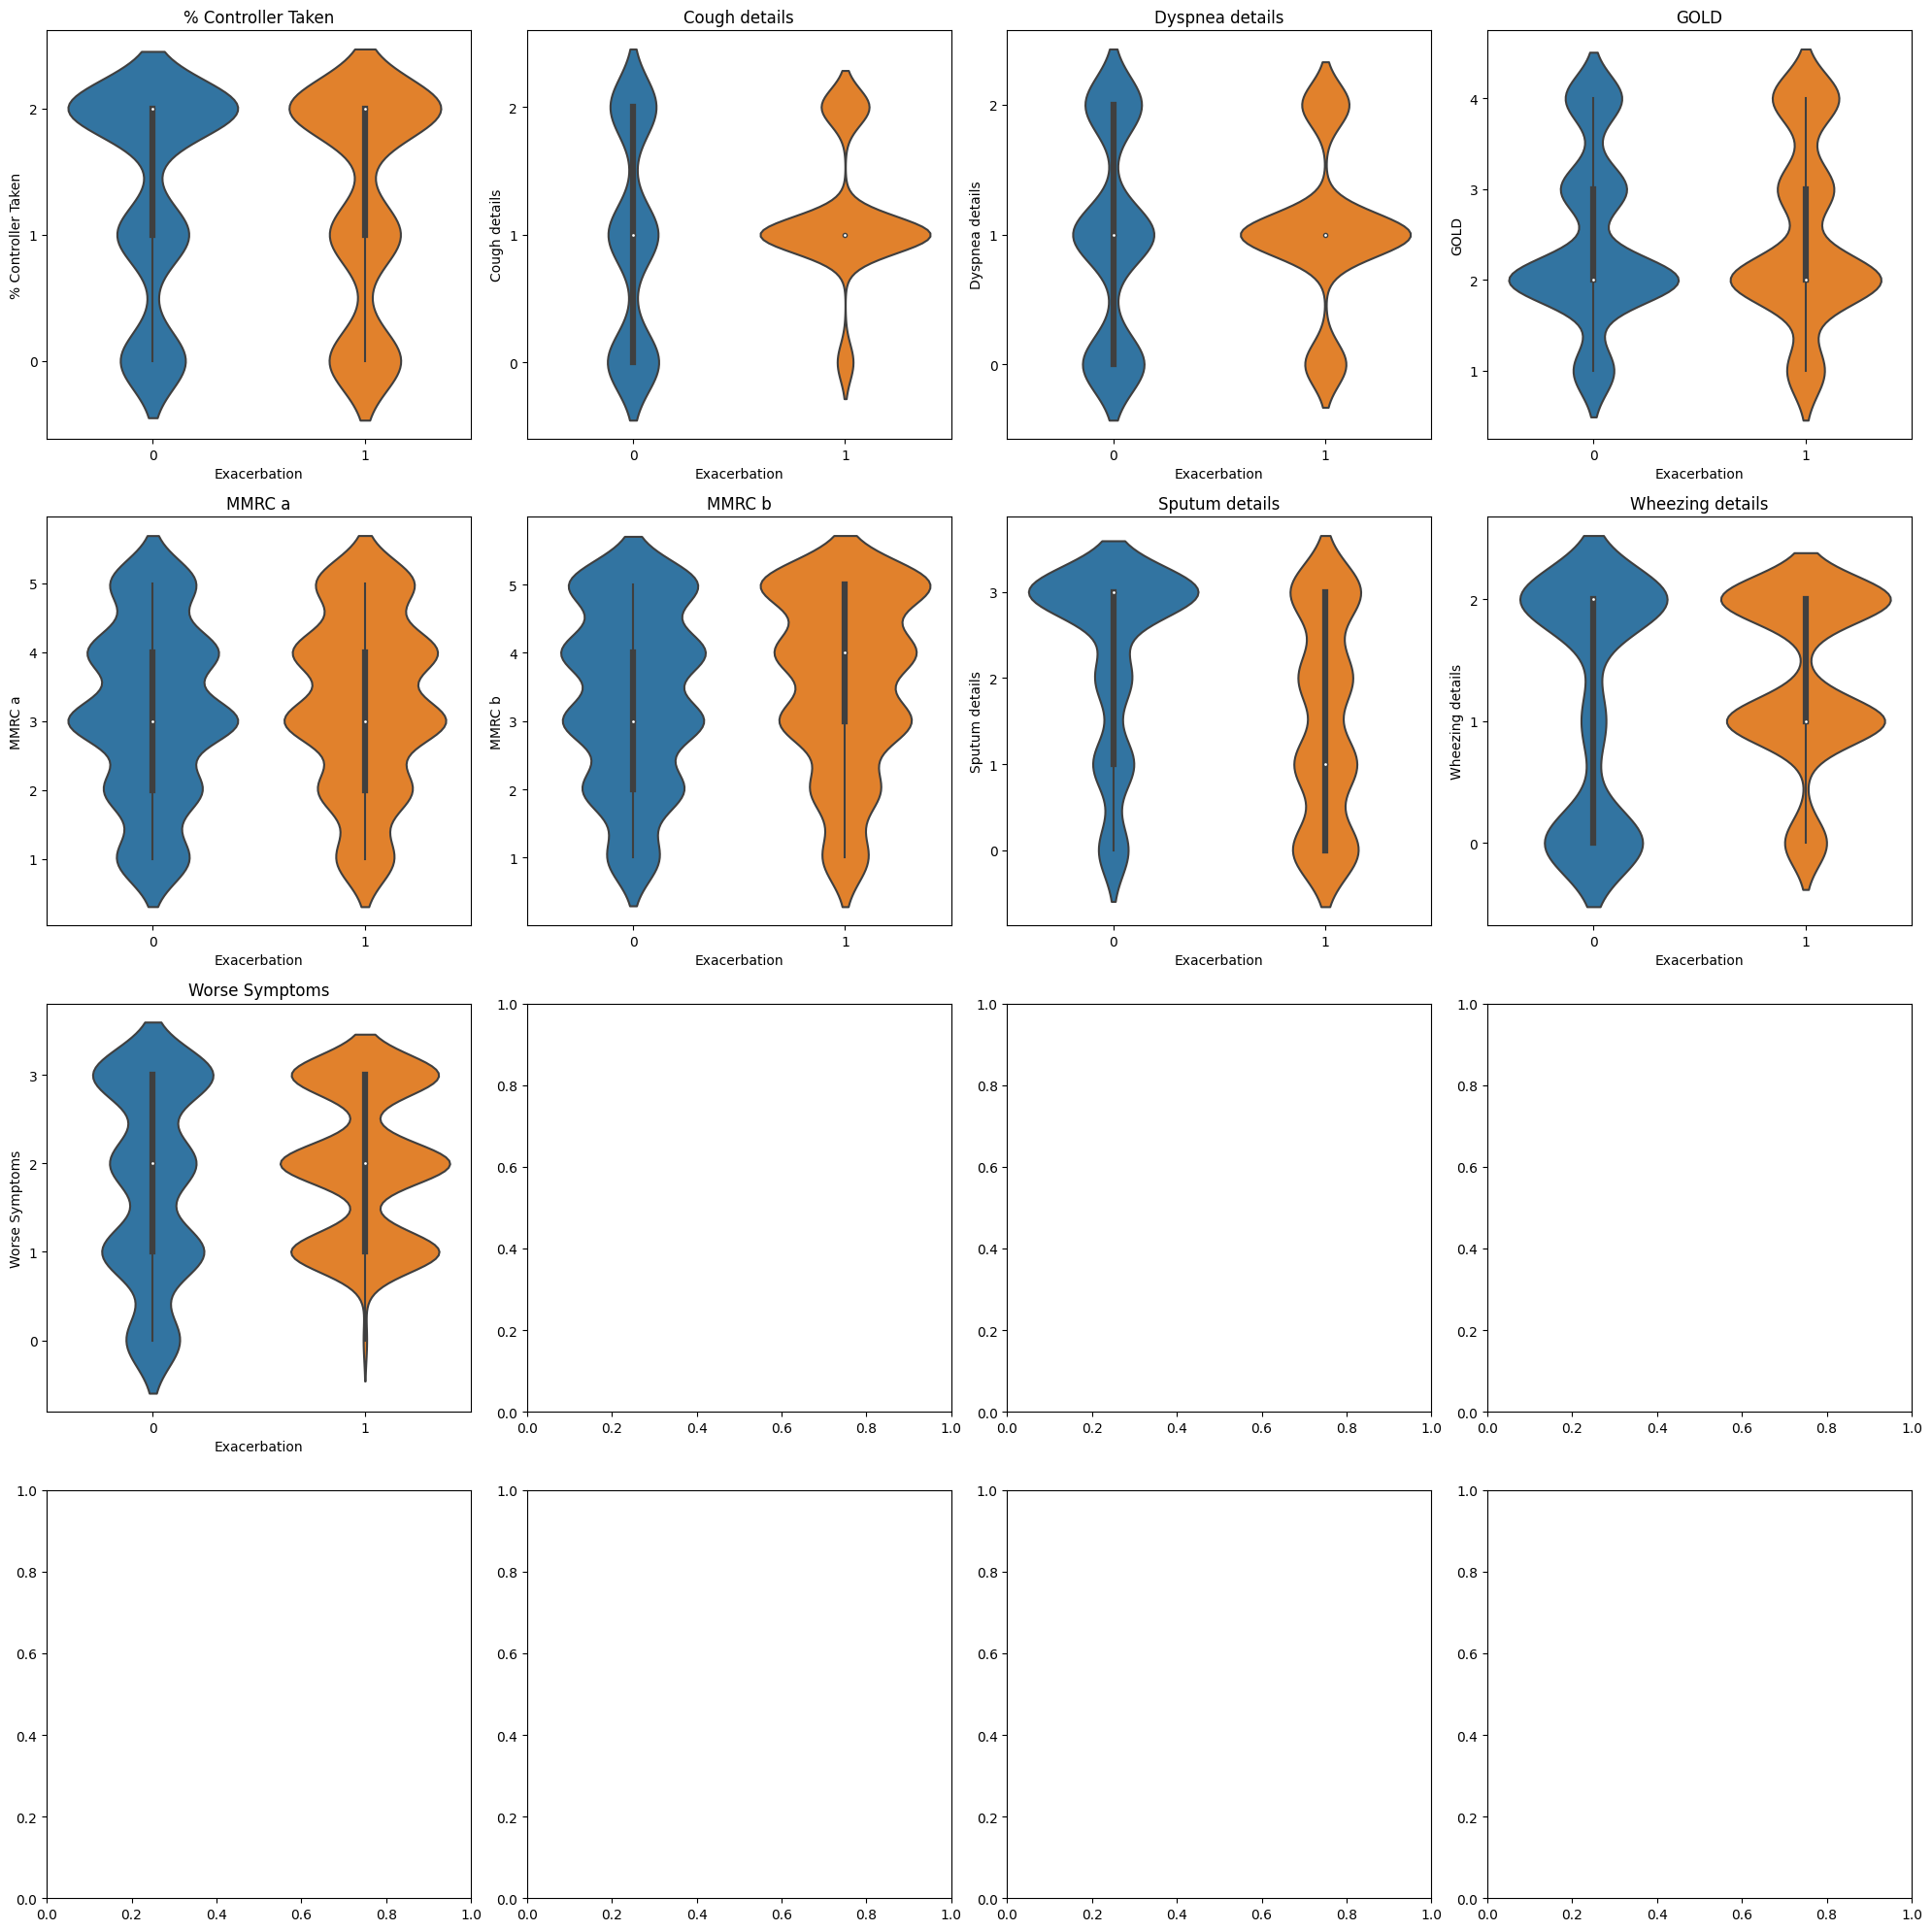

In [14]:
# plot all categorical vars vs target
fig, axs = plt.subplots(4, 4, figsize=(20, 20))
col = 0
row = 0
triage_viz = triage.copy()
# drop all rows with nan values
triage_viz[categorical_vars_triage] = triage_viz[categorical_vars_triage].fillna(triage_viz[categorical_vars_triage].mode().iloc[0])
for var in categorical_vars_triage:
    # do not consider nan values 
    if col == 4:
        col = 0
        row += 1
    # plot a line between mean value for exacerbation and non-exacerbation
    sns.violinplot(x='Exacerbation', y=var, data=triage_viz, ax=axs[row, col])
    axs[row, col].set_title(var)
    axs[row, col].set_yticks(triage_viz[var].unique())
    axs[row, col].set_ylabel(var)
    axs[row, col].set_xlabel('Exacerbation')
    col += 1

plt.tight_layout()

## Cramer's V

ValueError: Cannot use `hue` without `x` and `y`

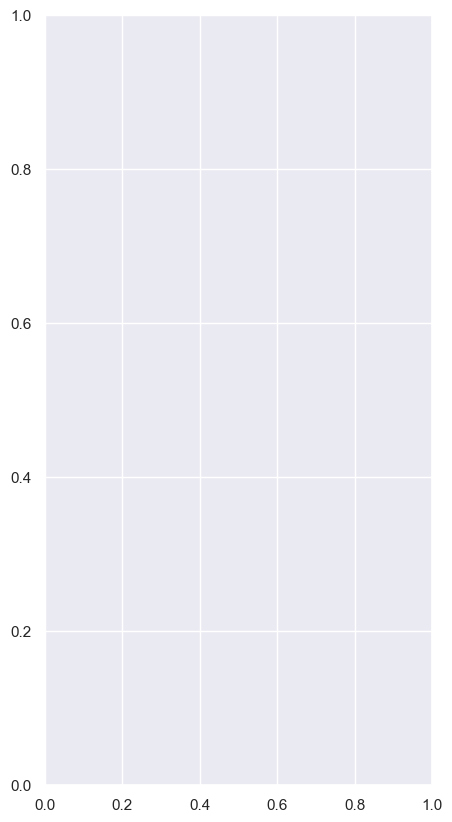

In [76]:
# calculate Cramer's V for all categorical variables
from scipy.stats import chi2_contingency

# calculate Cramer's V between the target (Exacerbation) and all categorical variables
cramers_v = []
triage_categorical = triage[categorical_vars_triage].copy()
for var in categorical_vars_triage:
    # calculate contingency table
    contingency_table = pd.crosstab(triage_categorical[var], triage['Exacerbation']).to_numpy()
    X2 = chi2_contingency(contingency_table, correction=False)[0]
    n = contingency_table.sum()
    phi2 = X2/n
    r,k = contingency_table.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    cramers_v.append(np.sqrt(phi2corr / min((kcorr-1), (rcorr-1))))
# sort by absolute value of cramers_v
cramers_v = pd.DataFrame({'Variable': categorical_vars_triage, 'Cramers_V': cramers_v})
cramers_v = cramers_v.reindex(cramers_v['Cramers_V'].abs().sort_values(ascending=False).index)
# set default sns style
# use default sns color palette
fig, ax = plt.subplots(figsize=(5, 10))
ax = sns.barplot(data=cramers_v, x= orient='h', palette='colorblind', hue='Cramers_V')
ax.grid(False, axis='x')
# add values to the bars
ax.bar_label(ax.containers[0], fmt='%.2f', label_type='edge', padding=5)
# set x axis limits
ax.set_xlim(0, 0.6)
plt.title("Association of categorical Triage variables with exacerbation outcome")
# center the title
ax.title.set_position([0.3, 1.05])
plt.xlabel("Cramer's V")


# save as svg to results folder
plt.savefig('./results/cramers_v_triage.svg', format='svg')
plt.savefig('./results/cramers_v_triage.png', format='png')

## Plot continuous

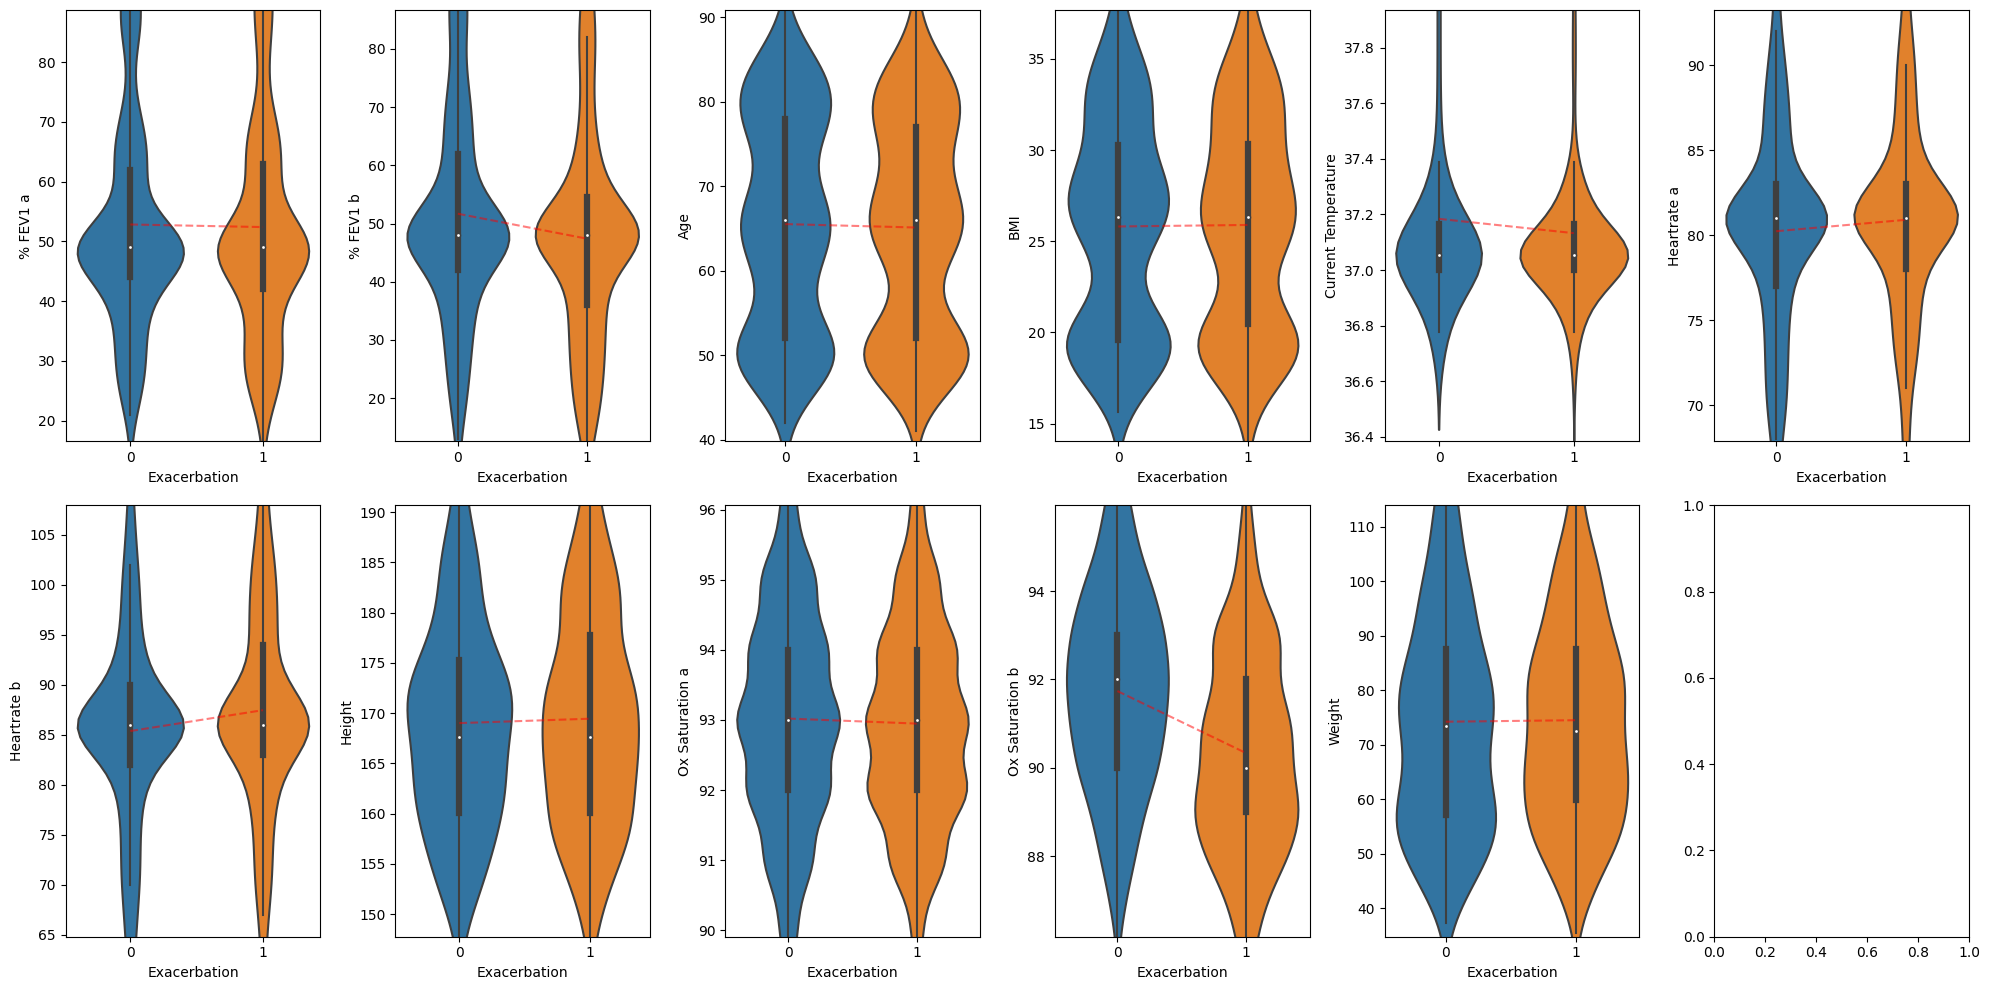

In [13]:
import seaborn as sns
# plot all continuous vars vs target
fig, axs = plt.subplots(2, 6, figsize=(20, 10))
col = 0
row = 0
triage_viz = triage.copy()
triage_viz[continuous_vars_triage] = triage_viz[continuous_vars_triage].fillna(triage_viz[continuous_vars_triage].median())
for var in continuous_vars_triage:
    if col == 6:
        col = 0
        row += 1
    # plot a violin plot for exacerbation at x=1 and one for no exacerbation at x=0
    sns.violinplot(x='Exacerbation', y=var, data=triage_viz, ax=axs[row, col])
    # move the y axis so that the mean value of the non-exacerbators is in the center
    axs[row, col].set_ylim(triage_viz[var].mean() - 2 * triage_viz[var].std(), triage_viz[var].mean() + 2 * triage_viz[var].std())
    # draw a line between the median values at 1 and the median values at 0
    axs[row, col].plot([0, 1], [triage_viz[triage_viz['Exacerbation'] == 0][var].mean(), triage_viz[triage_viz['Exacerbation'] == 1][var].mean()], color='red', alpha=0.5, linestyle='--')
    axs[row, col].set_xlabel('Exacerbation')
    axs[row, col].set_xticks([0, 1])
    axs[row, col].set_ylabel(var)
    col += 1

plt.tight_layout()
# save as svg to results folder
plt.savefig('./results/point_biserial_vis_triage.svg', format='svg')

## Point Biserial Correlation

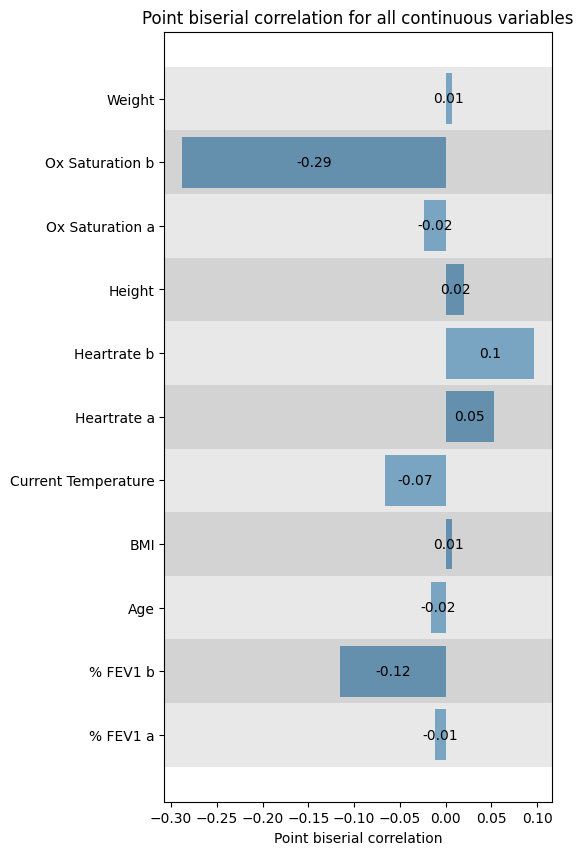

In [54]:
from scipy.stats import pointbiserialr
# calculate point biserial correlation for continuous variables
biserial_corr = []
triage_continuous = triage[continuous_vars_triage].copy()
for var in continuous_vars_triage:
    # drop all rows with nan values
    triage_continuous[var] = triage_continuous[var].fillna(triage_continuous[var].median())
    # calculate point biserial correlation
    biserial_corr.append(pointbiserialr(triage_continuous[var], triage['Exacerbation'])[0])

# plot point biserial correlation for all continuous variables
plt.figure(figsize=(5, 10))
# color all the plots in every second row to make it easier to read
plt.barh(continuous_vars_triage, biserial_corr)
    
# color the y ticks in every second row to make it easier to read
for i in range(len(continuous_vars_triage)):
    plt.text(biserial_corr[i] * 0.5, i, round(biserial_corr[i], 2), ha='center', va='center', color='black')
    if i % 2 == 0:
        plt.axhspan(i - 0.5, i + 0.5, facecolor='#d3d3d3', alpha=0.5)
        # if biserial_corr[i] > 0:
        #     plt.text(0.5 * biserial_corr[i], i, round(biserial_corr[i], 2), ha='center', va='center', color='white')
        # else:
        #     plt.text(0.5 * biserial_corr[i], i, round(biserial_corr[i], 2),  ha='center', va='center', color='white')
    else:
        plt.axhspan(i - 0.5, i + 0.5, facecolor='#a9a9a9', alpha=0.5)
        # if biserial_corr[i] > 0:
        #     plt.text(0.5 * biserial_corr[i], i, round(biserial_corr[i], 2), ha='center', va='center', color='white')
        # else:
        #     plt.text(0.5 * biserial_corr[i], i, round(biserial_corr[i], 2),  ha='center', va='center', color='white')
plt.title('Point biserial correlation for all continuous variables')
    
plt.xlabel('Point biserial correlation')
# save as svg to results folder
plt.savefig('./results/point_biserial_triage.svg', format='svg')

# Feature Importance and Multivariate Analysis

In [28]:
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

target = 'Exacerbation'

discrete_features_triage = triage.columns[triage.nunique() <= 5].drop(target)
continuous_features_triage = triage.columns[triage.nunique() > 5]
discrete_features_harvard = harvard.columns[harvard.nunique() <= 10].drop(target)
continuous_features_harvard = harvard.columns[harvard.nunique() > 10]


harvard_copy = harvard.copy()
harvard_copy.dropna(subset=[target], inplace=True)
triage_copy = triage.copy()
triage_copy.dropna(subset=[target], inplace=True)
# only consider smokers
# triage_copy = triage_copy[triage_copy['Smoker'] == 1]
X_harvard = harvard_copy.drop(target, axis=1)
X_triage = triage_copy.drop(target, axis=1)
mutual_info_split_harvard = pd.DataFrame(columns=sorted(X_harvard.columns))
mutual_info_split_triage = pd.DataFrame(columns=sorted(X_triage.columns))
rf_split_harvard = pd.DataFrame(columns=sorted(X_harvard.columns))
rf_split_triage = pd.DataFrame(columns=sorted(X_triage.columns))
# use median to impute NaN values
X_harvard = X_harvard.fillna(X_harvard.median())
X_harvard = StandardScaler().fit_transform(X_harvard)
# transform back to dataframe
X_harvard = pd.DataFrame(X_harvard, columns=harvard_copy.drop(target, axis=1).columns)

X_triage = X_triage.fillna(X_triage.median())
X_triage = StandardScaler().fit_transform(X_triage)
X_triage = pd.DataFrame(X_triage, columns=triage_copy.drop(target, axis=1).columns)

y_harvard = harvard_copy[target]
y_harvard = LabelEncoder().fit_transform(y_harvard)
y_triage = triage_copy[target]
y_triage = LabelEncoder().fit_transform(y_triage)
for i in range(100):
    # create a train test split to shuffle the data
    X_train_harvard, X_test_harvard, y_train_harvard, y_test_harvard = train_test_split(X_harvard, y_harvard, test_size=0.2, random_state=i)
    X_train_triage, X_test_triage, y_train_triage, y_test_triage = train_test_split(X_triage, y_triage, test_size=0.2, random_state=i)
    # infomation gain processing
    # mutual_info_harvard_discrete = mutual_info_classif(X_train_harvard[discrete_features_harvard], y_train_harvard, random_state=42, discrete_features=True)
    # mutual_info_harvard_continuous = mutual_info_classif(X_train_harvard[continuous_features_harvard], y_train_harvard, random_state=42, discrete_features=False)
    # mutual_info_harvard = np.concatenate((mutual_info_harvard_discrete, mutual_info_harvard_continuous), axis=0)
    mutual_info_harvard = mutual_info_classif(X_train_harvard, y_train_harvard, random_state=42)
    # mutual_info_triage_discrete = mutual_info_classif(X_train_triage[discrete_features_triage], y_train_triage, random_state=42, discrete_features=True)
    # mutual_info_triage_continuous = mutual_info_classif(X_train_triage[continuous_features_triage], y_train_triage, random_state=42, discrete_features=False)
    # mutual_info_triage = np.concatenate((mutual_info_triage_discrete, mutual_info_triage_continuous), axis=0)
    mutual_info_triage = mutual_info_classif(X_train_triage, y_train_triage, random_state=42)
    mutual_info_harvard = pd.DataFrame({'variable': X_harvard.columns, 'importances': mutual_info_harvard})
    mutual_info_triage = pd.DataFrame({'variable': X_triage.columns, 'importances': mutual_info_triage})
    # rf processing
    rf_importances_harvard = RandomForestClassifier(random_state=42).fit(X_train_harvard, y_train_harvard).feature_importances_
    rf_importances_triage = RandomForestClassifier(random_state=42).fit(X_train_triage, y_train_triage).feature_importances_
    rf_importances_harvard_df = pd.DataFrame({'variable': X_harvard.columns, 'importances': rf_importances_harvard})
    rf_importances_triage_df = pd.DataFrame({'variable': X_triage.columns, 'importances': rf_importances_triage})
    # sort by feature names
    mutual_info_harvard = mutual_info_harvard.sort_values('variable')
    mutual_info_triage = mutual_info_triage.sort_values('variable')
    rf_importances_harvard_df = rf_importances_harvard_df.sort_values('variable')
    rf_importances_triage_df = rf_importances_triage_df.sort_values('variable')
    # concat the importances to the dataframe. Keep the column index
    mutual_info_split_harvard = pd.concat([mutual_info_split_harvard, mutual_info_harvard.set_index('variable').T])
    mutual_info_split_triage = pd.concat([mutual_info_split_triage, mutual_info_triage.set_index('variable').T])
    rf_split_harvard = pd.concat([rf_split_harvard, rf_importances_harvard_df.set_index('variable').T])
    rf_split_triage = pd.concat([rf_split_triage, rf_importances_triage_df.set_index('variable').T])

mutual_info_split_harvard_medians = mutual_info_split_harvard.median()
mutual_info_split_triage_medians = mutual_info_split_triage.median()
rf_split_harvard_medians = rf_split_harvard.median()
rf_split_triage_medians = rf_split_triage.median()

# sort the columns according to their medians
mutual_info_split_harvard_medians = mutual_info_split_harvard_medians.sort_values(ascending=False)
mutual_info_split_triage_medians = mutual_info_split_triage_medians.sort_values(ascending=False)
rf_split_harvard_medians = rf_split_harvard_medians.sort_values(ascending=False)
rf_split_triage_medians = rf_split_triage_medians.sort_values(ascending=False)

# sort the columns in the split similarly
mutual_info_split_harvard_sorted = mutual_info_split_harvard[mutual_info_split_harvard_medians.index]
mutual_info_split_triage_sorted = mutual_info_split_triage[mutual_info_split_triage_medians.index]
rf_split_harvard_sorted = rf_split_harvard[rf_split_harvard_medians.index]
rf_split_triage_sorted = rf_split_triage[rf_split_triage_medians.index]

['% FEV1 a', '% FEV1 b', 'Age', 'Asthma', 'BMI', 'Congestive Heart Failure', 'Coronary Artery Disease', 'Diabetes', 'Exacerbation', 'GOLD', 'Gender, Male', 'Height', 'Hospitalized last year', 'Hypertension', 'ICU last year', 'Kidney disease', 'Oxygen Therapy', 'Weight', 'MMRC a', 'MMRC b', 'MMRC']


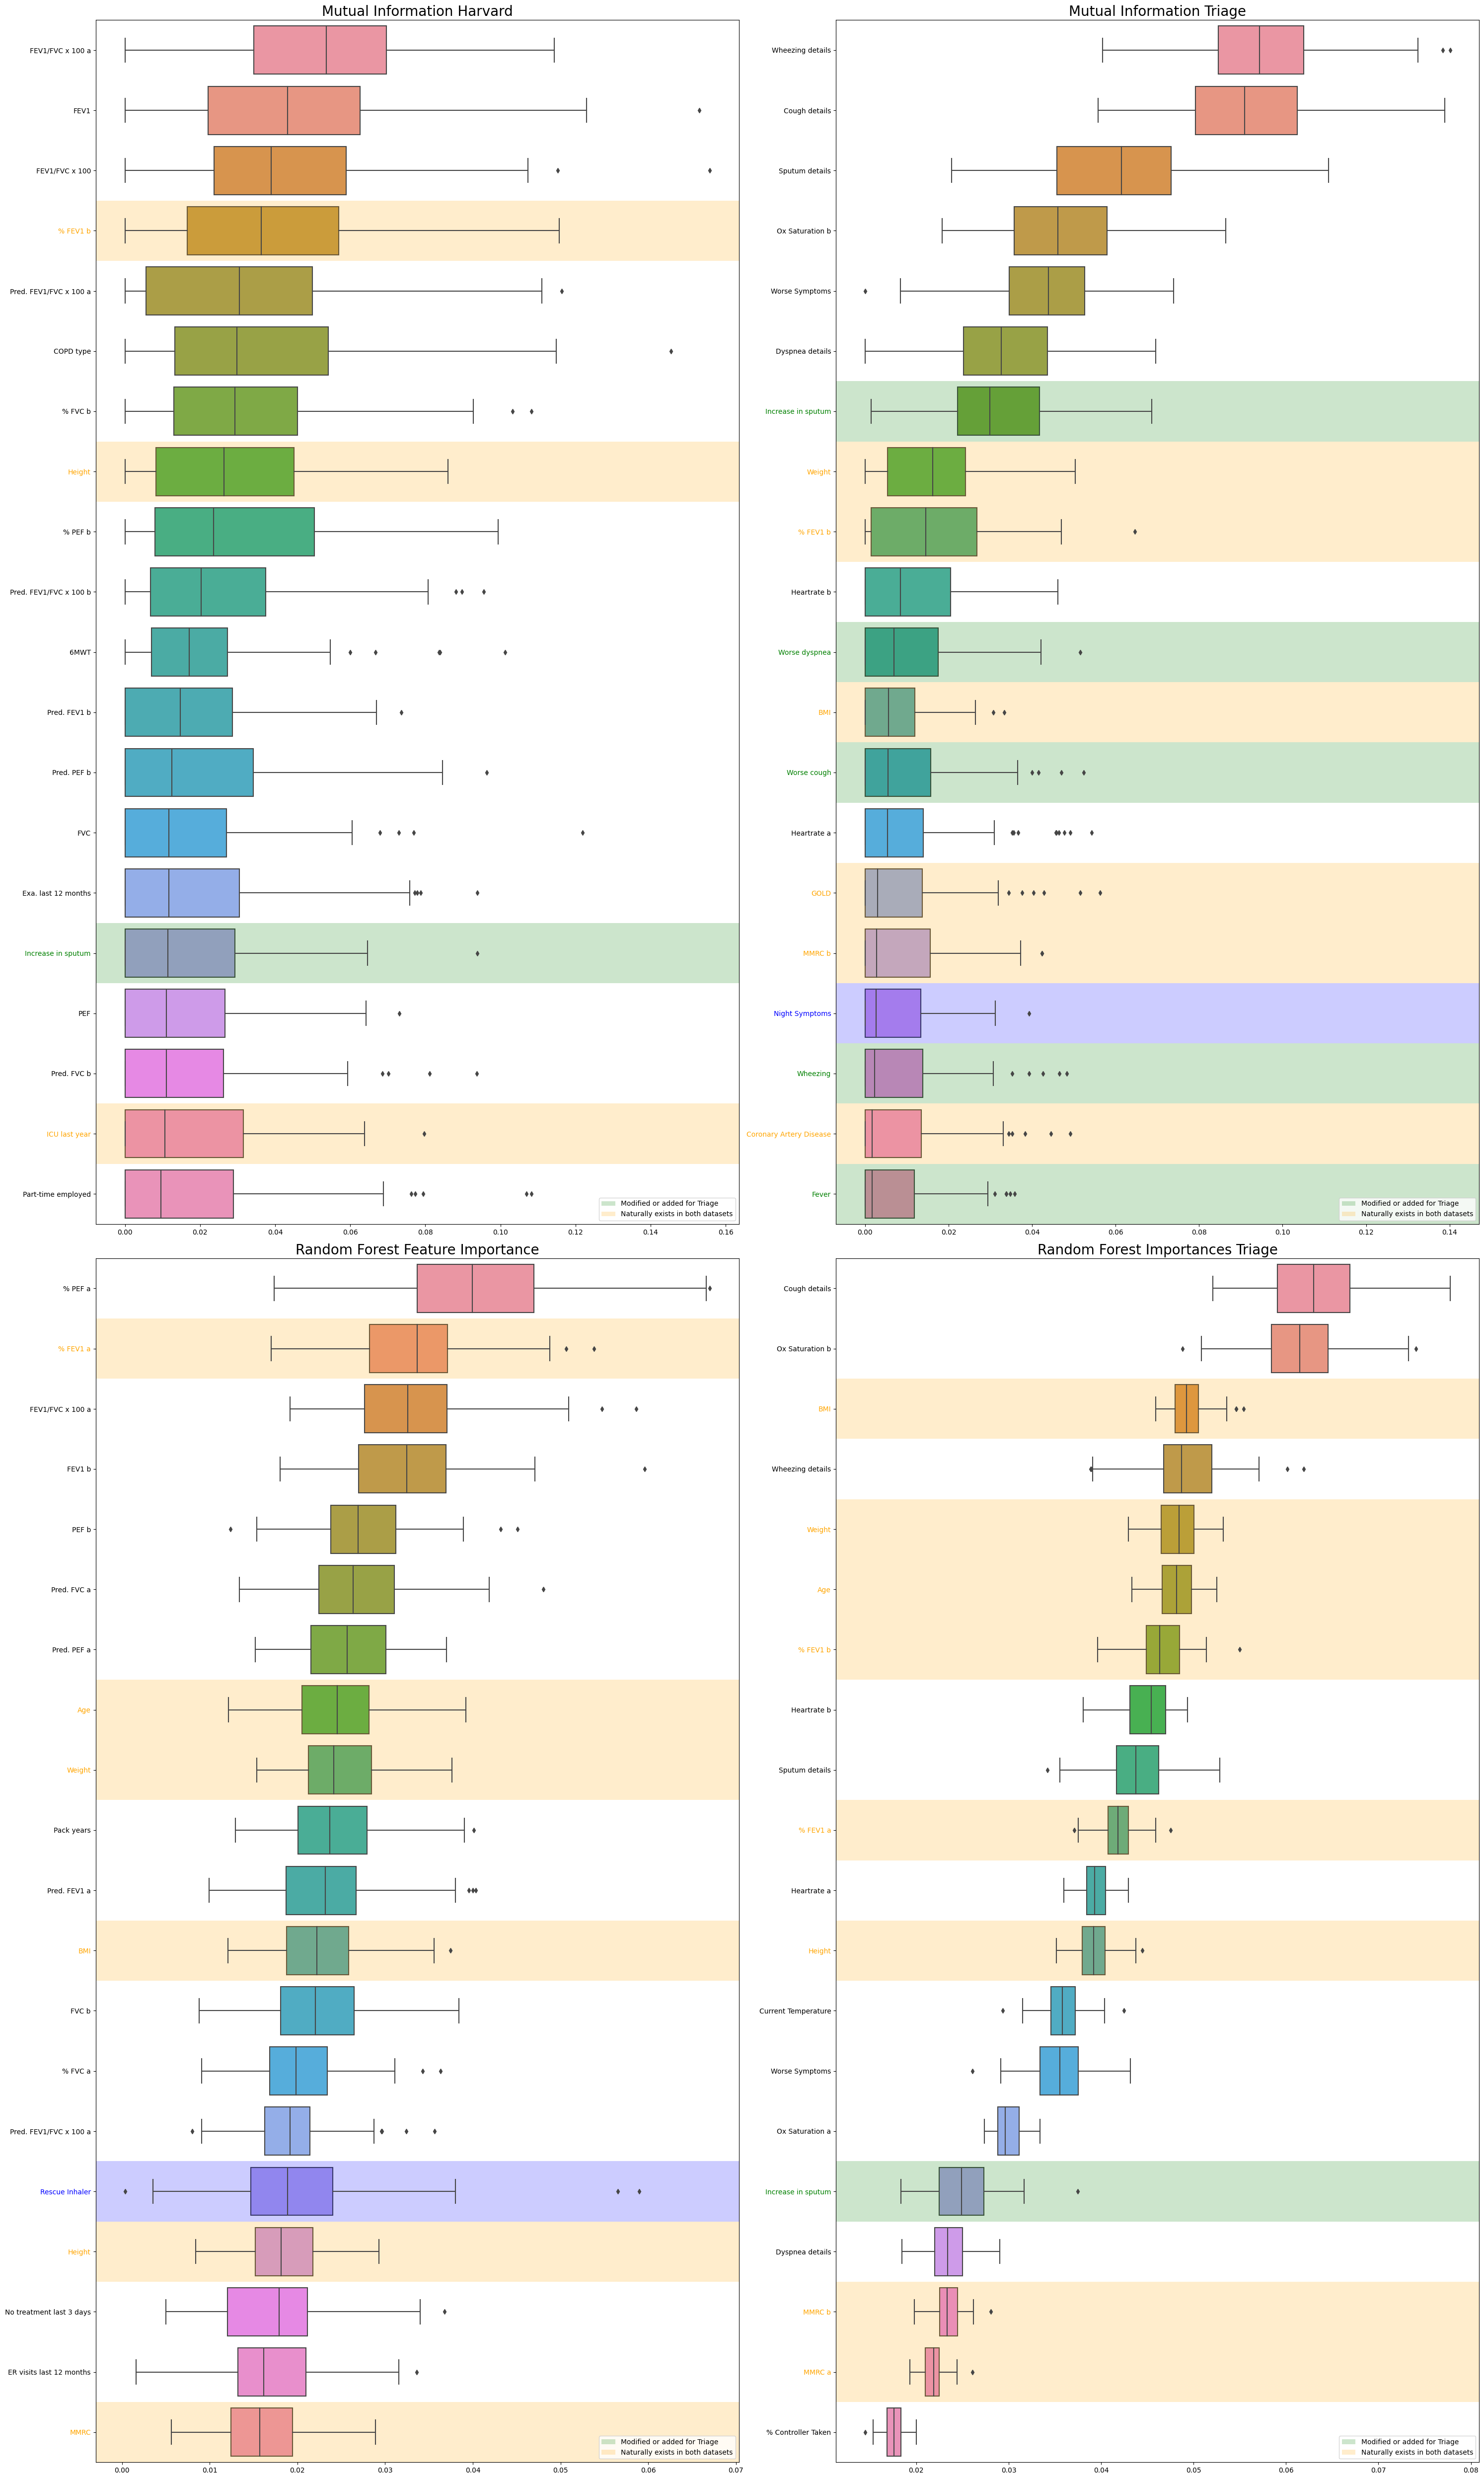

In [30]:
import matplotlib as mpl


modified_triage = ['Increase in sputum',  'Fever', 'Wheezing', 'Worse dyspnea', 'Worse cough']
modified_harvard = ['Night Symptoms', 'Rescue Inhaler', '2+ Exa. last year', 'Lives Alone', 'Daily Inhaler', 'Pill to control Exa.']
naturally_existing_in_both = [var for var in triage_copy if (var in harvard_copy.columns and var not in modified_triage and var not in modified_harvard)]
# append MMRC a, MMRC b and MMRC
naturally_existing_in_both.append('MMRC a')
naturally_existing_in_both.append('MMRC b')
naturally_existing_in_both.append('MMRC')
print(naturally_existing_in_both)

# prevent svg backend from rendering text as paths
new_rc_params = {'text.usetex': False,
"svg.fonttype": 'none'
}
mpl.rcParams.update(new_rc_params)

# create subplots with 4 large figures
fig, axs = plt.subplots(2, 2, figsize=(30, 50))
axs[0,0].set_title('Mutual Information Harvard', fontsize=20)
# axs[0].set_xlabel('Information Gain', fontsize=40)
axs[0,1].set_title('Mutual Information Triage', fontsize=20)
# axs[1].set_xlabel('Information Gain', fontsize=40)
axs[1,0].set_title('Random Forest Feature Importance', fontsize=20)
# axs[2].set_xlabel('Random Forest Importances', fontsize=40)
axs[1,1].set_title('Random Forest Importances Triage', fontsize=20)
# axs[3].set_xlabel('Random Forest Feature Importance', fontsize=40)

# variables_count_difference = len(harvard_copy.columns) - len(triage_copy.columns)
# print(variables_count_difference)
# pd.options.mode.chained_assignment = None
# # add that many variables to the end of the triage dataframes
# for i in range(variables_count_difference):
#     mutual_info_split_triage_sorted.loc['empty' + str(i)] = 0
#     rf_split_triage_sorted.loc['empty' + str(i)] = 0

# create a horzontal box plot of top 20 features
sns.boxplot(data=mutual_info_split_harvard_sorted.iloc[:, :20], orient='h', ax=axs[0,0])
sns.boxplot(data=mutual_info_split_triage_sorted.iloc[:, :20], orient='h', ax=axs[0,1])
sns.boxplot(data=rf_split_harvard_sorted.iloc[:, :20], orient='h', ax=axs[1,0])
sns.boxplot(data=rf_split_triage_sorted.iloc[:, :20], orient='h', ax=axs[1,1])

# set the labels containg the word "empty to false"

# for i in range(len(mutual_info_split_triage.columns)):
#     # get the y_label at this position
#     y_label = mutual_info_split_triage_sorted.columns[i]
#     # if the label contains the word "empty"
#     if "empty" in y_label:
#         # set the label to false
#         axs[1].get_yticklabels()[i].set_visible(False)
#         axs[3].get_yticklabels()[i].set_visible(False)

# highlight all the variables that are also in the other dataset
for i in range(20):
    if mutual_info_split_harvard_sorted.columns[i] in naturally_existing_in_both:
        axs[0,0].axhspan(i - 0.5, i + 0.5, facecolor='orange', alpha=0.2, label='Naturally exists in both datasets')
        axs[0,0].get_yticklabels()[i].set_color("orange")
    if mutual_info_split_harvard_sorted.columns[i] in modified_harvard:
        axs[0,0].axhspan(i - 0.5, i + 0.5, facecolor='blue', alpha=0.2, label='Modified or added for Harvard')
        axs[0,0].get_yticklabels()[i].set_color("blue")
    if mutual_info_split_harvard_sorted.columns[i] in modified_triage:
        axs[0,0].axhspan(i - 0.5, i + 0.5, facecolor='green', alpha=0.2, label='Modified or added for Triage')
        axs[0, 0].get_yticklabels()[i].set_color("green")
    if rf_split_harvard_sorted.columns[i] in naturally_existing_in_both:
        axs[1,0].axhspan(i - 0.5, i + 0.5, facecolor='orange', alpha=0.2, label='Naturally exists in both datasets')
        axs[1,0].get_yticklabels()[i].set_color("orange")
    if rf_split_harvard_sorted.columns[i] in modified_harvard:
        axs[1,0].axhspan(i - 0.5, i + 0.5, facecolor='blue', alpha=0.2, label='Modified or added for Harvard')
        axs[1,0].get_yticklabels()[i].set_color("blue")
    if rf_split_harvard_sorted.columns[i] in modified_triage:
        axs[1,0].axhspan(i - 0.5, i + 0.5, facecolor='green', alpha=0.2, label='Modified or added for Triage')
        axs[1,0].get_yticklabels()[i].set_color("green")

for i in range(20):
    if mutual_info_split_triage_sorted.columns[i] in naturally_existing_in_both:
        axs[0,1].axhspan(i - 0.5, i + 0.5, facecolor='orange', alpha=0.2, label='Naturally exists in both datasets')
        axs[0,1].get_yticklabels()[i].set_color("orange")
    if mutual_info_split_triage_sorted.columns[i] in modified_harvard:
        axs[0,1].axhspan(i - 0.5, i + 0.5, facecolor='blue', alpha=0.2, label='Modified or added for Harvard')
        axs[0,1].get_yticklabels()[i].set_color("blue")
    if mutual_info_split_triage_sorted.columns[i] in modified_triage:
        axs[0,1].axhspan(i - 0.5, i + 0.5, facecolor='green', alpha=0.2, label='Modified or added for Triage')
        axs[0,1].get_yticklabels()[i].set_color("green")
    if rf_split_triage_sorted.columns[i] in naturally_existing_in_both:
        axs[1,1].axhspan(i - 0.5, i + 0.5, facecolor='orange', alpha=0.2, label='Naturally existing in both datasets')
        axs[1,1].get_yticklabels()[i].set_color("orange")
    if rf_split_triage_sorted.columns[i] in modified_harvard:
        axs[1,1].axhspan(i - 0.5, i + 0.5, facecolor='blue', alpha=0.2, label='Modified or added for Harvard')
        axs[1,1].get_yticklabels()[i].set_color("blue")
    if rf_split_triage_sorted.columns[i] in modified_triage:
        axs[1,1].axhspan(i - 0.5, i + 0.5, facecolor='green', alpha=0.2, label='Modified or added for Triage')
        axs[1,1].get_yticklabels()[i].set_color("green")

# # create one legend for the whole figure with labels 'Feature naturally existing in both datasets', 'Feature modified in or added to Harvard', 'Feature modified in or added to Triage'
desired_labels = ['Modified or added for Harvard', 'Modified or added for Triage', 'Naturally exists in both datasets']
all_handles, all_labels = axs[0,0].get_legend_handles_labels()

# Create dictionaries to store desired handles and labels
custom_handles_dict = {}
custom_labels_dict = {}

for handle, label in zip(all_handles, all_labels):
    if label in desired_labels:
        custom_handles_dict[label] = handle
        custom_labels_dict[label] = label

# Create a custom legend with only the desired labels and handles
custom_handles = [custom_handles_dict[label] for label in desired_labels if label in custom_handles_dict]
custom_labels = [custom_labels_dict[label] for label in desired_labels if label in custom_handles_dict]

# set font size of the x and y ticks
for ax in axs.flat:
    ax.tick_params(axis='x', labelsize=10)
    ax.tick_params(axis='y', labelsize=10)
    ax.legend(custom_handles, custom_labels, loc='lower right', fontsize=10)

# # make sure legend is under the figures
fig.tight_layout()
plt.savefig('all_feature_importances_2.svg', format='svg', dpi=1200, )

plt.show()

Plot how the number of features by importance influences model performance over time

In [36]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.pipeline import Pipeline

classifiers = [RandomForestClassifier(random_state=42, n_jobs=-1, class_weight='balanced_subsample'),  KNeighborsClassifier(n_jobs=-1), XGBClassifier(random_state=42, n_jobs=-1, class_weight='balanced_subsample'), SVC(random_state=42, class_weight='balanced'), LogisticRegression(random_state=42, n_jobs=-1, class_weight='balanced'), GaussianNB()]

X_harvard = harvard_copy.drop(target, axis=1)
X_harvard.fillna(X_harvard.median(), inplace=True)
X_triage = triage_copy.drop(target, axis=1)
X_triage.fillna(X_triage.median(), inplace=True)
y_harvard = harvard_copy[target]
y_triage = triage_copy[target]

mutual_info_results_harvard = dict().fromkeys([classifier.__class__.__name__ for classifier in classifiers])
mutual_info_results_harvard = {k: [] for k in mutual_info_results_harvard}
mutual_info_results_triage = dict().fromkeys([classifier.__class__.__name__ for classifier in classifiers])
mutual_info_results_triage = {k: [] for k in mutual_info_results_triage}
rf_results_harvard = dict().fromkeys([classifier.__class__.__name__ for classifier in classifiers])
rf_results_harvard = {k: [] for k in rf_results_harvard}
rf_results_triage = dict().fromkeys([classifier.__class__.__name__ for classifier in classifiers])
rf_results_triage = {k: [] for k in rf_results_triage}

stratified_kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for classifier in classifiers:
    print(classifier.__class__.__name__)
    name = classifier.__class__.__name__
    classifier = Pipeline([('scaler', StandardScaler()), ('classifier', classifier)])
    # for 3 to len(X.columns) features test which amount of features is the best
    for i in range(3, len(X_harvard.columns)):
        # get the top i columns
        top_i_mi_features_harvard = mutual_info_split_harvard_sorted.iloc[:, :i].columns
        top_i_rf_features_harvard = rf_split_harvard_sorted.iloc[:, :i].columns
        X_slice_mi_harvard = X_harvard[top_i_mi_features_harvard].to_numpy()
        X_slice_rf_harvard = X_harvard[top_i_rf_features_harvard].to_numpy()
        # mutual info
        mutual_info_results_harvard[name].append(cross_val_score(classifier, X_slice_mi_harvard, y_harvard, cv=stratified_kfold, scoring='roc_auc', n_jobs=-1).mean())
        # random forest
        rf_results_harvard[name].append(cross_val_score(classifier, X_slice_rf_harvard, y_harvard, cv=stratified_kfold, scoring='roc_auc',  n_jobs=-1).mean())
    # for 3 to len(X.columns) features test which amount of features is the best
    for i in range(3, len(X_triage.columns)):
        # get the top i columns
        top_i_mi_features_triage = mutual_info_split_triage_sorted.iloc[:, :i].columns
        top_i_rf_features_triage = rf_split_triage_sorted.iloc[:, :i].columns
        X_slice_mi_triage = X_triage[top_i_mi_features_triage].to_numpy()
        X_slice_rf_triage = X_triage[top_i_rf_features_triage].to_numpy()
        # mutual info
        mutual_info_results_triage[name].append(cross_val_score(classifier, X_slice_mi_triage, y_triage, cv=stratified_kfold, scoring='roc_auc',  n_jobs=-1).mean())
        # random forest
        rf_results_triage[name].append(cross_val_score(classifier, X_slice_rf_triage, y_triage, cv=stratified_kfold, scoring='roc_auc',  n_jobs=-1).mean())

RandomForestClassifier
KNeighborsClassifier
XGBClassifier
SVC
LogisticRegression
GaussianNB


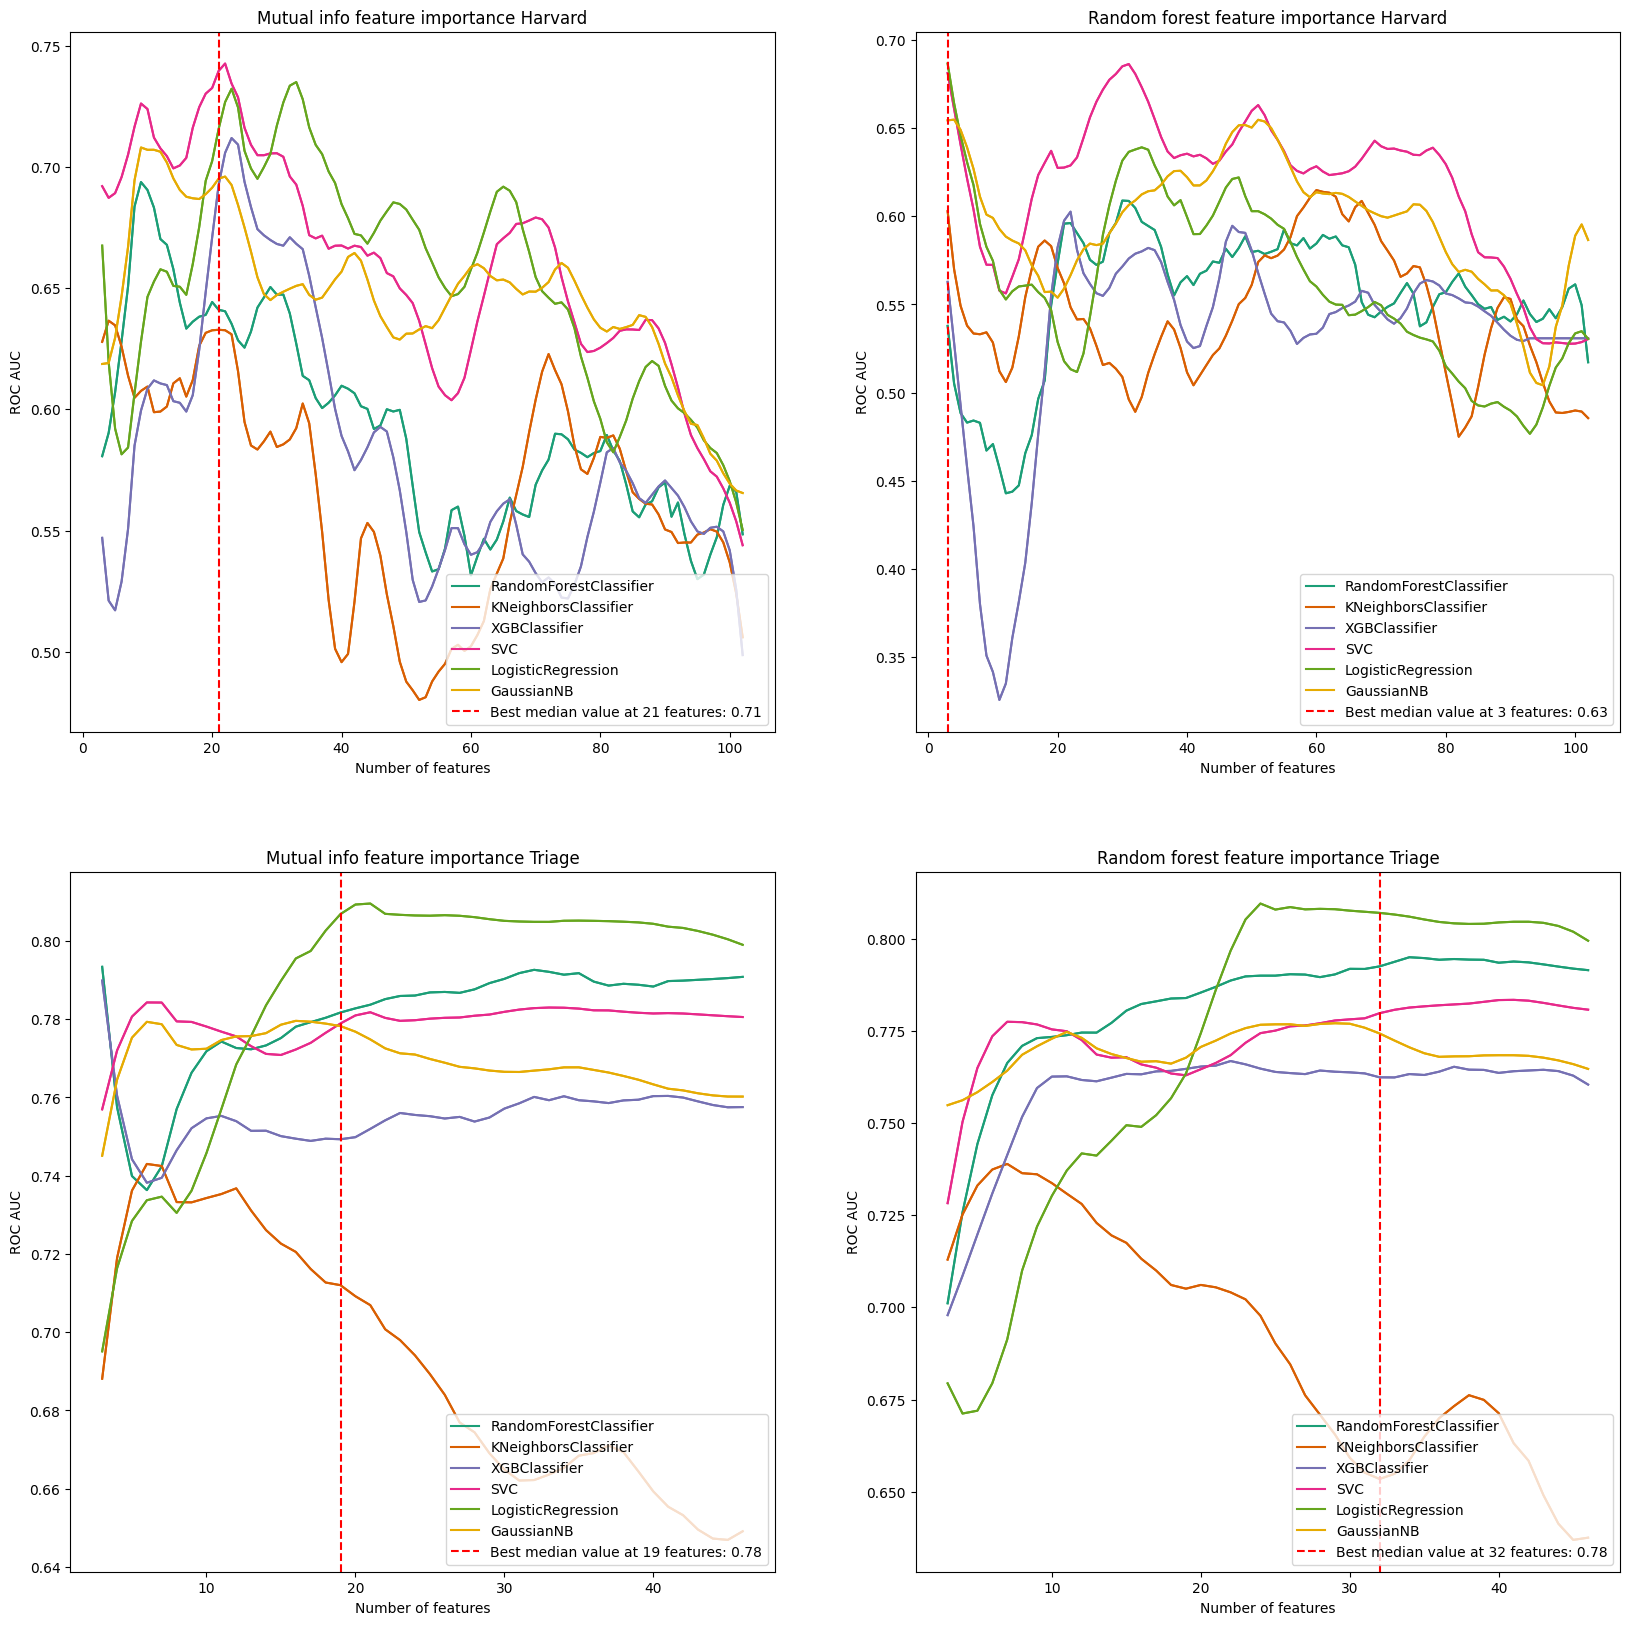

In [37]:
from scipy.signal import savgol_filter

colors = plt.get_cmap("Dark2")
# create a 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(20, 20))
i = 0
for key, value in mutual_info_results_harvard.items():
    # smooth the curve
    axes[0, 0].plot(range(3, len(X_harvard.columns)), savgol_filter(value, 10, 3),  color = colors(i))
    # add a smooth curve through the points
    axes[0, 0].plot(range(3, len(X_harvard.columns)), savgol_filter(value, 10, 3), label=key, color = colors(i))
    i += 1
i = 0
for key, value in rf_results_harvard.items():
    axes[0, 1].plot(range(3, len(X_harvard.columns)), savgol_filter(value, 10, 3),  color = colors(i))
    # add a smooth curve through the points
    axes[0, 1].plot(range(3, len(X_harvard.columns)), savgol_filter(value, 10, 3), label=key, color = colors(i))
    i += 1
i = 0
for key, value in mutual_info_results_triage.items():
    axes[1, 0].plot(range(3, len(X_triage.columns)), savgol_filter(value, 10, 3),  color = colors(i))
    # add a smooth curve through the points
    axes[1, 0].plot(range(3, len(X_triage.columns)), savgol_filter(value, 10, 3), label=key, color = colors(i))
    i += 1
i = 0
for key, value in rf_results_triage.items():
    axes[1, 1].plot(range(3, len(X_triage.columns)), savgol_filter(value, 10, 3),  color = colors(i))
    # add a smooth curve through the points
    axes[1, 1].plot(range(3, len(X_triage.columns)), savgol_filter(value, 10, 3), label=key, color = colors(i))
    i += 1


# calculate the median of all 3 classifiers
median_mi_harvard = np.median([value for key, value in mutual_info_results_harvard.items()], axis=0)
median_mi_triage = np.median([value for key, value in mutual_info_results_triage.items()], axis=0)

# the value with the highest median is the best
best_mi_harvard = np.argmax(median_mi_harvard) + 3
best_mi_value_harvard = np.round(np.max(median_mi_harvard), 2)
best_mi_triage = np.argmax(median_mi_triage) + 3
best_mi_value_triage = np.round(np.max(median_mi_triage), 2)
median_rf_harvard = np.median([value for key, value in rf_results_harvard.items()], axis=0)
median_rf_triage = np.median([value for key, value in rf_results_triage.items()], axis=0)
best_rf_harvard = np.argmax(median_rf_harvard) + 3 
best_rf_value_harvard = np.round(np.max(median_rf_harvard), 2)
best_rf_triage = np.argmax(median_rf_triage) + 3
best_rf_value_triage = np.round(np.max(median_rf_triage), 2)

# add a vertical line at the best value
axes[0,0].axvline(best_mi_harvard, color='r', linestyle='--', label='Best median value at {} features: {}'.format(best_mi_harvard, best_mi_value_harvard))
axes[1,0].axvline(best_mi_triage, color='r', linestyle='--', label='Best median value at {} features: {}'.format(best_mi_triage, best_mi_value_triage))
axes[0,1].axvline(best_rf_harvard, color='r', linestyle='--', label='Best median value at {} features: {}'.format(best_rf_harvard, best_rf_value_harvard))
axes[1,1].axvline(best_rf_triage, color='r', linestyle='--', label='Best median value at {} features: {}'.format(best_rf_triage, best_rf_value_triage))

axes[0,0].set_title('Mutual info feature importance Harvard')
axes[0,0].set_xlabel('Number of features')
axes[0,0].set_ylabel('ROC AUC')
axes[0,1].set_title('Random forest feature importance Harvard')
axes[0,1].set_xlabel('Number of features')
axes[0,1].set_ylabel('ROC AUC')
axes[1,0].set_title('Mutual info feature importance Triage')
axes[1,0].set_xlabel('Number of features')
axes[1,0].set_ylabel('ROC AUC')
axes[1,1].set_title('Random forest feature importance Triage')
axes[1,1].set_xlabel('Number of features')
axes[1,1].set_ylabel('ROC AUC')


# add legend for every axes
for ax in axes.flat:
    ax.legend(loc='lower right')

## Descriptive Stats Traige

In [6]:
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from scipy.stats import norm
import statsmodels.api as sm

# binary columns are variables with only 2 values
binary_cols = triage.columns[triage.nunique() == 2].drop('Exacerbation')
count_dataframe = pd.DataFrame(columns=['Exacerbation', 'No Exacerbation', 'Odds Ratio'])
# add row n with the count of exacerbations
exa_count = triage['Exacerbation'][triage['Exacerbation'] == 1].count()
no_exa_count = triage['Exacerbation'][triage['Exacerbation'] == 0].count()
count_dataframe.loc['n'] = exa_count, no_exa_count, ""
for var in binary_cols:
    # the Exacerbation column is all values where fclinra08 is 1 and the value in col is the positive value
    exa_col_count = [triage['Exacerbation'][triage['Exacerbation'] == 1][triage[var] == 1].count()]
    exa_percentage = round(exa_col_count[0] / exa_count * 100, 2)
    exa_col_string = str(exa_col_count[0]) + ' (' + str(exa_percentage) + '%)'
    no_exa_col_count = [triage['Exacerbation'][triage['Exacerbation'] == 0][triage[var] == 1].count()]
    no_exa_percentage = round(no_exa_col_count[0] / no_exa_count * 100, 2)
    no_exa_col_string = str(no_exa_col_count[0]) + ' (' + str(no_exa_percentage) + '%)'
    # fit a logistic model to calculate the odds ratio
    X = triage[var]
    # drop all rows with nan values
    X = X[~np.isnan(X)]
    y = triage['Exacerbation']
    y = y[X.index]
    X = X.values.reshape(-1, 1)
    y = LabelEncoder().fit_transform(y)
    # calculate odds ratio for this variable using stats model
    sm_model = sm.Logit(y, sm.add_constant(X)).fit(disp=False)
    # get 95% CI for odds ratio
    ci = sm_model.conf_int(alpha=0.05, cols=None)
    # calculate odds ratio
    odds_ratio = np.exp(sm_model.params[1])
    # calculate lower and upper bound of 95% CI
    lower_bound = np.exp(ci[0][1])
    upper_bound = np.exp(ci[1][1])
    # create a string for the odds ratio and 95% CI
    odds_ratio_string = str(round(odds_ratio, 2)) + ' (' + str(round(lower_bound, 2)) + '-' + str(round(upper_bound, 2)) + ')'
    # add the counts to the dataframe
    count_dataframe.loc[var] = exa_col_string, no_exa_col_string, odds_ratio_string

# sort by effect size
count_dataframe.sort_values(by='Odds Ratio', ascending=False, inplace=True)

# now look at numeric variables
numeric_cols = triage.columns[triage.nunique() > 2]
mean_dataframe = pd.DataFrame(columns=['Exacerbation', 'No Exacerbation', 'Odds Ratio'])
for var in numeric_cols:
    positives = triage[var][triage['Exacerbation'] == 1]
    negatives = triage[var][triage['Exacerbation'] == 0]
    # get the mean + std for the exacerbation group with only 2 decimal places
    exacerbation_mean = round([positives.mean()][0], 2)
    exacerbation_std = round([positives.std()][0], 2)
    # create a string for the mean +- std
    exacerbation_string = str(exacerbation_mean) + u"(" + str(exacerbation_std) +")"
    # get the mean + std for the no exacerbation group
    no_exacerbation_mean = round([negatives.mean()][0], 2)
    no_exacerbation_std = round([negatives.std()][0], 2)
    # create a string for the mean +- std
    no_exacerbation_string = str(no_exacerbation_mean) + u"(" + str(no_exacerbation_std) +")"
    std_exa = triage[var][triage['Exacerbation'] == 1].std()
    # effect size 1 (Glass's delta) with Exacerbation group variance that we want to emphasize
    #effect_size = np.round((exacerbation_mean - no_exacerbation_mean) / std_exa, 2)
    X = triage[var]
    # drop all rows with nan values
    X = X[~np.isnan(X)]
    y = triage['Exacerbation']
    # match the indices of X and y
    y = y[X.index]
    X = X.values.reshape(-1, 1)
    y = LabelEncoder().fit_transform(y)
     # calculate odds ratio for this variable using stats model
    sm_model = sm.Logit(y, sm.add_constant(X)).fit(disp=False)
    ci = sm_model.conf_int(alpha=0.05, cols=None)
    # calculate odds ratio
    odds_ratio = np.exp(sm_model.params[1])
    # calculate lower and upper bound of 95% CI
    lower_bound = np.exp(ci[0][1])
    upper_bound = np.exp(ci[1][1])
    # create a string for the odds ratio and 95% CI
    odds_ratio_string = str(round(odds_ratio, 2)) + ' (' + str(round(lower_bound, 2)) + '-' + str(round(upper_bound, 2)) + ')'

    # add the strings to the dataframe
    mean_dataframe.loc[var] = exacerbation_string, no_exacerbation_string, odds_ratio_string

# sort by effect size
mean_dataframe.sort_values(by='Odds Ratio', ascending=False, inplace=True)

# concat both dataframes
descriptive_stats = pd.concat([count_dataframe, mean_dataframe], axis=0)


# export to csv
descriptive_stats.to_csv('./triage_descriptive_stats_2.csv', sep=';', decimal=',', encoding='utf-8')